# Analysis

## Description
This notebook performs analysis on the pre-processed, QC'd, clustered, and annotated sc object, we produced in scanpyQC.ipynb.

### Initializing AnnData object

Let us first load packages and initialise some settings.

In [1]:
import os
import numpy as np
import pandas as pd
import anndata as ad
import scanpy as sc
import seaborn as sns
from scipy.stats import median_abs_deviation,false_discovery_control
import scipy.io as sio
import logging
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
import random
import sc_toolbox
import diffxpy.api as de
import gseapy as gp
from gseapy import Msigdb
import scranPY

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.figsize'] = (15, 15)
sc.logging.print_header()

os.makedirs("analysis/plots/trajectoryPlots/", exist_ok = True) 
os.makedirs("analysis/plots/RFplots/", exist_ok = True) 
os.makedirs("analysis/plots/diffExp/", exist_ok = True) 
os.makedirs("analysis/objects", exist_ok = True) 
os.makedirs("analysis/diffExp", exist_ok = True) 
os.makedirs("analysis/gsea", exist_ok = True) 
SEED=123
random.seed(SEED)

/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/numba/core/cpu.py:99: UserWarning: Numba extension module 'sparse._numba_extension' failed to load due to 'ModuleNotFoundError(No module named 'numba.targets')'.
  numba.core.entrypoints.init_all()


scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.24.4 scipy==1.11.3 pandas==2.1.1 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


In [2]:
import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro
from rpy2.robjects import r
rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

- Project '~/bioinformatics/projects/DaniSC/code/analysis' loaded. [renv 1.0.2]

NOTE: Dependency discovery took 690 seconds during snapshot.
Consider using .renvignore to ignore files, or switching to explicit snapshots.
See `?renv::dependencies` for more information.


Warning messages:
1: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
2: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
3: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
4: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
5: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
6: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
/tmp/ipykernel_15162/1129487915.py:7: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


First we load our QC'd anndata object.

In [194]:
adata = sc.read_h5ad("analysis/objects/postQC.h5ad")

In [195]:
adata

AnnData object with n_obs × n_vars = 11903 × 32165
    obs: 'ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'iterativeLeiden', 'parentLeiden', 'cellType', 'refinedCelltypes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_deviant', 'binomial_deviance', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'cellType_colors', 'dea_leiden', 'dendrogram_iterativeLeiden', 'dendrogram_refinedCelltypes', 'hvg', 'iterativeLeiden_colors', 'log1p', 'neighbors', 'parentLeiden_colors', 'pca', 'refinedCelltypes_colors', 'umap'
    obsm: 'X_pca', 'X_um

## Assess differential expression between KO and WT seperately for each cluster

Compute Size Factors

Current smallest cluster =  92  cells.
Using max_size =  3000 , clusters have been split into  19  clusters.
min_mean =  0.1


/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/scranPY/main.py:171: RuntimeWarning: divide by zero encountered in divide
  rescaling[clust] = np.nanmedian(cur_prof / ref_prof)


--- 2.05 mins ---
size factor min =  0.2954171872126111
size factor max =  10.567511406045762


/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/scanpy/plotting/_utils.py:715: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  color = color[sort]


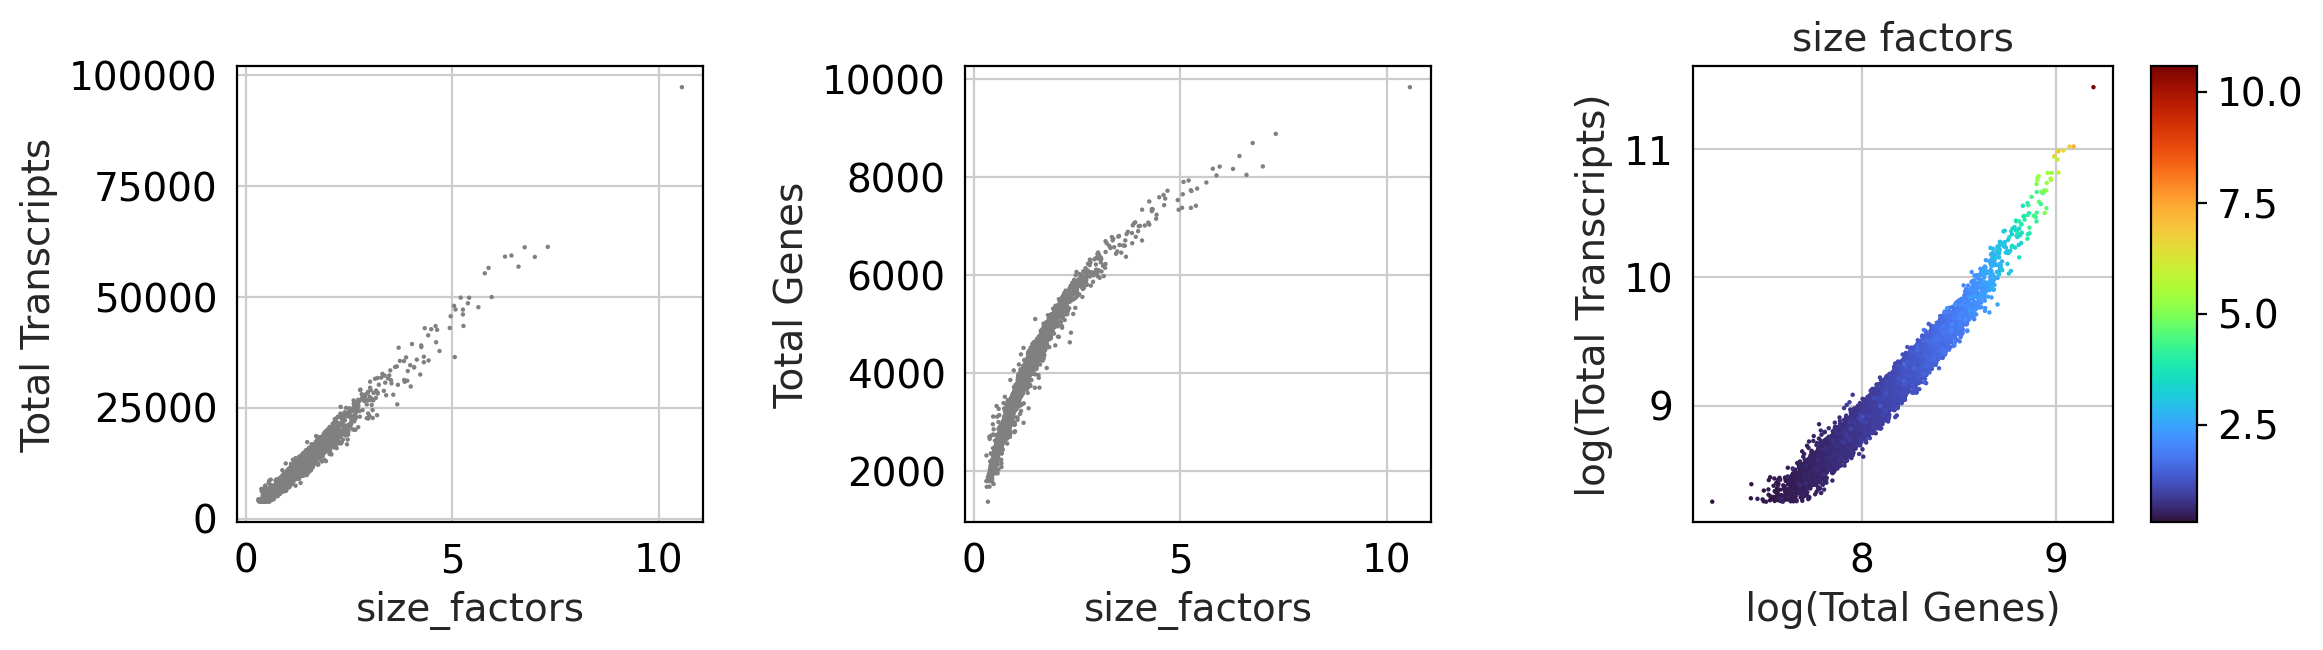

<Figure size 1500x1500 with 0 Axes>

In [211]:
adataSF = adata.copy()
adataSF.X = adataSF.X.toarray()
#Group smaller clusters for size factor inference
adataSF.obs["refinedCelltypes"] = adataSF.obs["refinedCelltypes"].apply(lambda x: "Pericyte" if (x == "Microglia") | (x == "Endothelium") else x)
scranPY.compute_sum_factors(adataSF, clusters='refinedCelltypes', parallelize=True, algorithm='CVXPY', max_size=3000)
adata.obs["size_factors"] = adataSF.obs["size_factors"]
del adataSF

Set correct order for comparisons - so it's KO vs WT not WT vs KO

In [212]:
adata.obs.ID = adata.obs.ID.cat.reorder_categories(['WT', 'KO'], ordered=True)

### Let's use a function to run some basic differential expression on each cluster

In [213]:
from itertools import chain
def diffExp(adata, groupVar, cluster, expThresh=0.1):
    
    #Subset adata to this cluster
    adataClus = adata[adata.obs['refinedCelltypes'].isin([cluster])]
    
    #Remove genes not expressed in more than expThresh proportion of cells from either group from this cluster
    genes = set(chain.from_iterable([gene for gene in adataClus.var_names[sc.pp.filter_genes(adataClus[adataClus.obs[groupVar] == group], inplace=False, min_cells = expThresh*adataClus.shape[0])[0]]] for group in adataClus.obs[groupVar].unique()))
    
    #Test for differential expression
    res = de.test.wald(
    data=adataClus[:,adataClus.var_names.isin(genes)],
    formula_loc="~ 1 + ID + size_factors",
    factor_loc_totest="ID",
    as_numeric=["size_factors"]
    )
    return res

In [ ]:
#Cide to run sequentially
#test_part = {cluster: diffExp(adata, "ID", cluster) for cluster in adata.obs['refinedCelltypes'].unique()}

In [215]:
#Run diffExp in parallel
from multiprocess import Pool
with Pool(processes=10) as p:
    test_part = p.map(lambda cluster: diffExp(adata, cluster), adata.obs['refinedCelltypes'].unique())
test_part

Now lets add the results to the sc object for safe keeping, after adjusting for multiple testing and preparing for GSEA

In [216]:
def recomputePadj(df):
    df["qval"] = false_discovery_control(df["pval"], method='bh')
    return(df)

def gseaPrep(df):
    df = df[["gene", "log2fc"]]
    df = df.sort_values("log2fc", ascending=False)
    df = df.set_index("gene")
    return(df)

def colPicker(fc, pval, pvalthresh=0.05, fcthresh = 0.75):
    if pval < pvalthresh:
         if fc > fcthresh:
            return('p<0.05 fc>1')
         elif fc < -fcthresh:
            return('p<0.05 fc<-1')
         else:
            return('p<0.05')
    else:
        return('p>0.05')

In [217]:
summary = {cluster: test_part[cluster].summary() for cluster in test_part.keys()}
summary = {cluster: summary[cluster][summary[cluster]["mean"] > 0.25] for cluster in summary.keys()}
summary = {cluster: recomputePadj(summary[cluster]) for cluster in summary.keys()}
adata.uns["diffExp"] = summary

In [218]:
summary["GABA.Pro Tfap2b+"]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Xkr4,0.000000,0.000000,1.065533,1.300231,False,2.554064e-07,1.065533,0.112729,-1248.123414
1,Mrpl15,0.831286,0.928914,-0.020690,0.521940,False,5.374016e-05,-0.020690,0.097114,-822.415670
2,Lypla1,0.405593,0.666457,0.118948,0.285219,False,1.141781e-07,0.118948,0.143022,-577.748160
3,Tcea1,0.422817,0.677325,0.057537,0.981524,False,9.318217e-04,0.057537,0.071783,-1094.742340
4,Atp6v1h,0.639762,0.832365,0.039455,0.846420,False,1.628426e-07,0.039455,0.084300,-1043.164206
...,...,...,...,...,...,...,...,...,...,...
5960,mt-Cytb,0.337339,0.609070,0.025215,17.868360,False,8.158033e-08,0.025215,0.026281,-2842.455640
5961,CAAA01118383.1,0.739143,0.881298,0.048243,0.262125,False,2.928014e-09,0.048243,0.144879,-548.469205
5962,Vamp7,0.950444,0.980384,-0.006622,0.494226,False,4.759738e-09,-0.006622,0.106548,-800.676232
5963,Tmlhe,0.077441,0.269845,-0.263859,0.319861,False,9.088066e-09,-0.263859,0.149433,-609.621282


In [219]:
summary["GABA.IN"]

,gene,pval,qval,log2fc,mean,zero_mean,grad,coef_mle,coef_sd,ll
0,Xkr4,0.941717,0.993296,0.012396,2.886700,False,1.902303e-07,0.012396,0.169550,-423.948332
1,Mrpl15,0.382382,0.849484,0.185479,0.502463,False,2.497202e-03,0.185479,0.212336,-176.527823
2,Lypla1,0.195483,0.750577,-0.438527,0.266010,False,2.519625e-01,-0.438527,0.338755,-54.833232
3,Tcea1,0.411483,0.857988,0.116781,1.147783,False,1.511163e-05,0.116781,0.142192,-269.069997
4,Atp6v1h,0.512690,0.901418,0.109144,0.995074,False,1.450307e-06,0.109144,0.166720,-257.040528
...,...,...,...,...,...,...,...,...,...,...
6877,mt-Nd6,0.213949,0.759799,-0.321507,0.527094,False,8.688743e-07,-0.321507,0.258700,-169.268226
6878,mt-Cytb,0.398553,0.852504,0.043590,24.817734,False,3.215271e-07,0.043590,0.051634,-703.292881
6880,Vamp7,0.236800,0.773520,0.268576,0.487685,False,5.736518e-09,0.268576,0.227025,-187.224156
6881,Tmlhe,0.575771,0.922797,-0.188792,0.408867,False,5.640809e-07,-0.188792,0.337386,-161.376774


### Volcano plots of diff Exp results

In [220]:
from adjustText import adjust_text
def volcanoPlot(df, point_radius=4, pvalthresh=0.05, fcthresh=0.75, pvalMax=1e-10, save = None):

    df["colors"] = [colPicker(fc, pval, pvalthresh, fcthresh) for fc,pval in zip(df["log2fc"], df["qval"])]
    
    pvals = [pvalMax if pval < pvalMax else pval for pval in df["qval"] ]
    df["transformed_pvals"] = list(-1*np.log10(np.array(pvals)))
    ax = sns.scatterplot(data = df, x = 'log2fc', y = 'transformed_pvals',
                    hue = 'colors', hue_order = ['p>0.05', 'p<0.05', 'p<0.05 fc<-1', 'p<0.05 fc>1'],
                    palette = ['lightgrey', 'orange', 'blue', 'red'],
                    #style = 'shape', style_order = ['picked3', 'picked4', 'not_important'],
                    #markers = ['^', 's', 'o'], 
                    size = 'mean', sizes = (40, 400))
    ax.axhline(-1*np.log10(pvalthresh), zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(fcthresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    ax.axvline(-fcthresh, zorder = 0, c = 'k', lw = 2, ls = '--')
    
    texts = [plt.text(x = df.iloc[i].log2fc, y = df.iloc[i].transformed_pvals, s = df.iloc[i].gene,
                                 fontsize = 12, weight = 'bold') for i in range(len(df)) if (abs(df.iloc[i].log2fc) > fcthresh) and (df.iloc[i].qval < pvalthresh)]
            
    adjust_text(texts, arrowprops = dict(arrowstyle = '-', color = 'k'))
    
    plt.legend(loc = 1, bbox_to_anchor = (1.4,1), frameon = False, prop = {'weight':'bold'})
    
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2)
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.tick_params(width = 2)
    
    plt.xticks(size = 12, weight = 'bold')
    plt.yticks(size = 12, weight = 'bold')
    
    plt.xlabel("$log_{2}$ fold change", size = 15)
    plt.ylabel("-$log_{10}$ FDR", size = 15)
    
    if save != None:
        plt.savefig(save, dpi = 300, bbox_inches = 'tight', facecolor = 'white')
    
    plt.show()

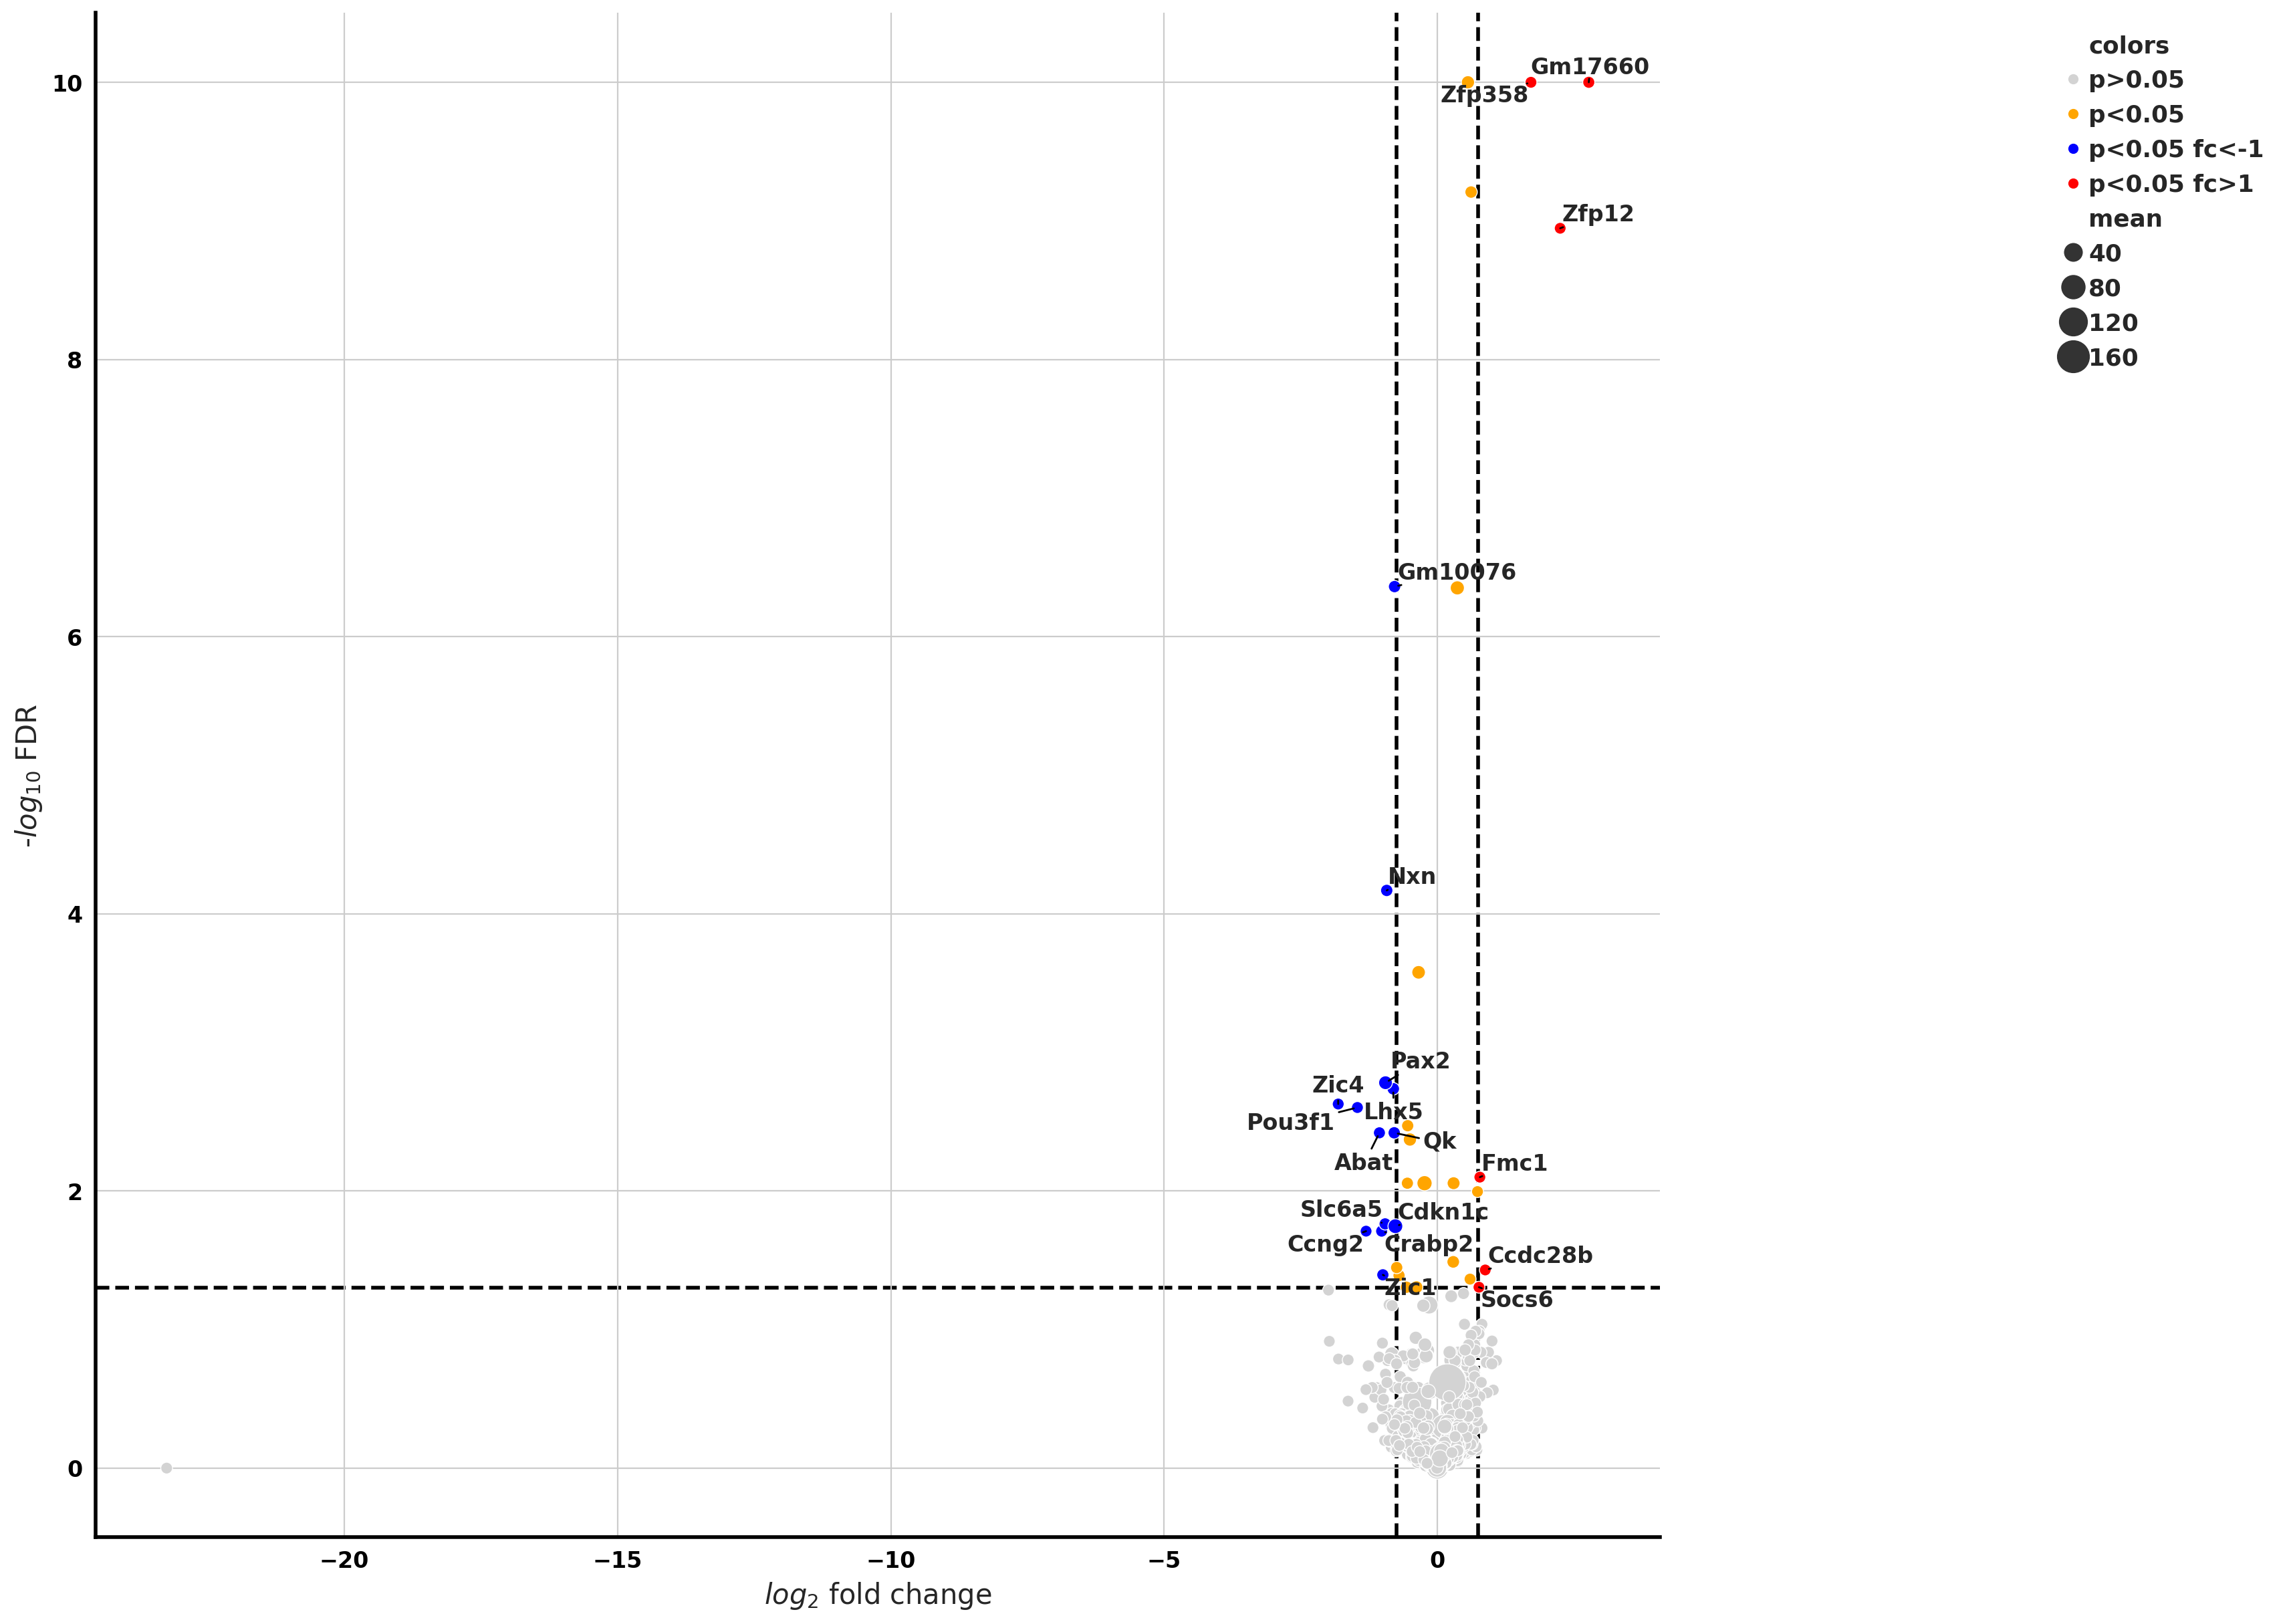

In [221]:
volcanoPlot(summary["GABA.IN"])

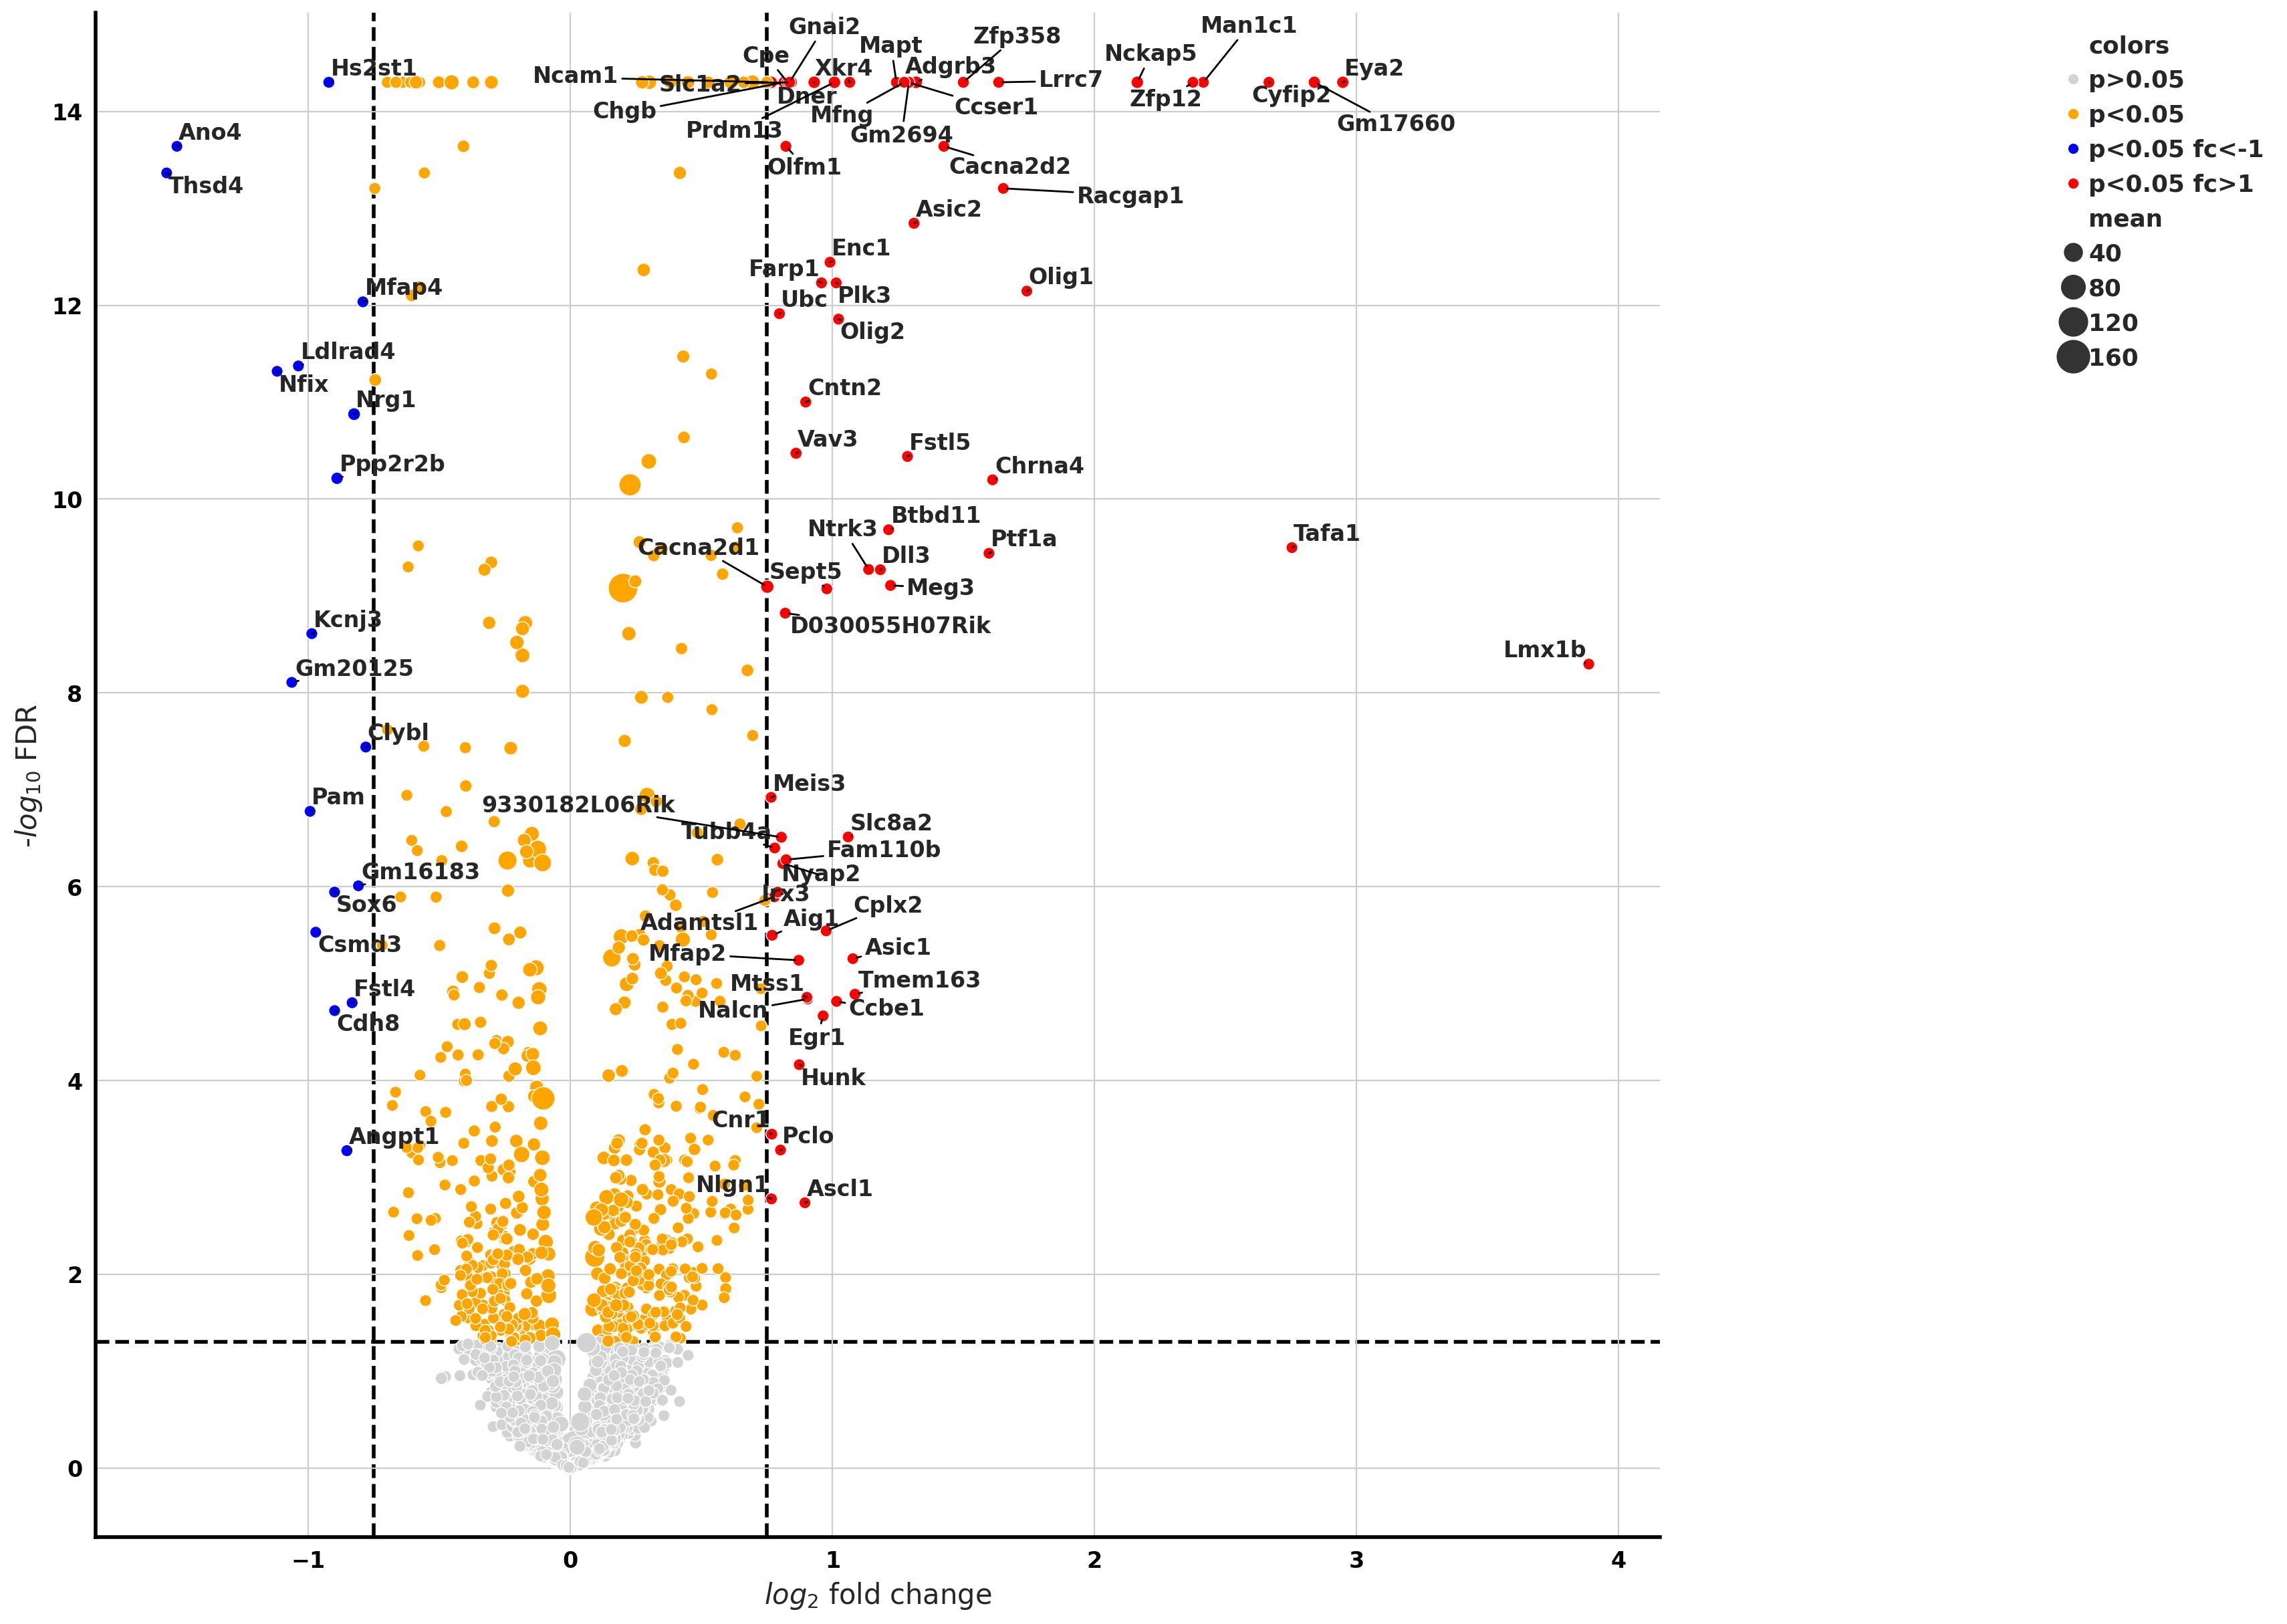

In [222]:
volcanoPlot(summary["GABA.Pro Tfap2b+"], pvalMax = 5e-15, save = "analysis/plots/diffExp/Tfap2b+_vol.jpg")

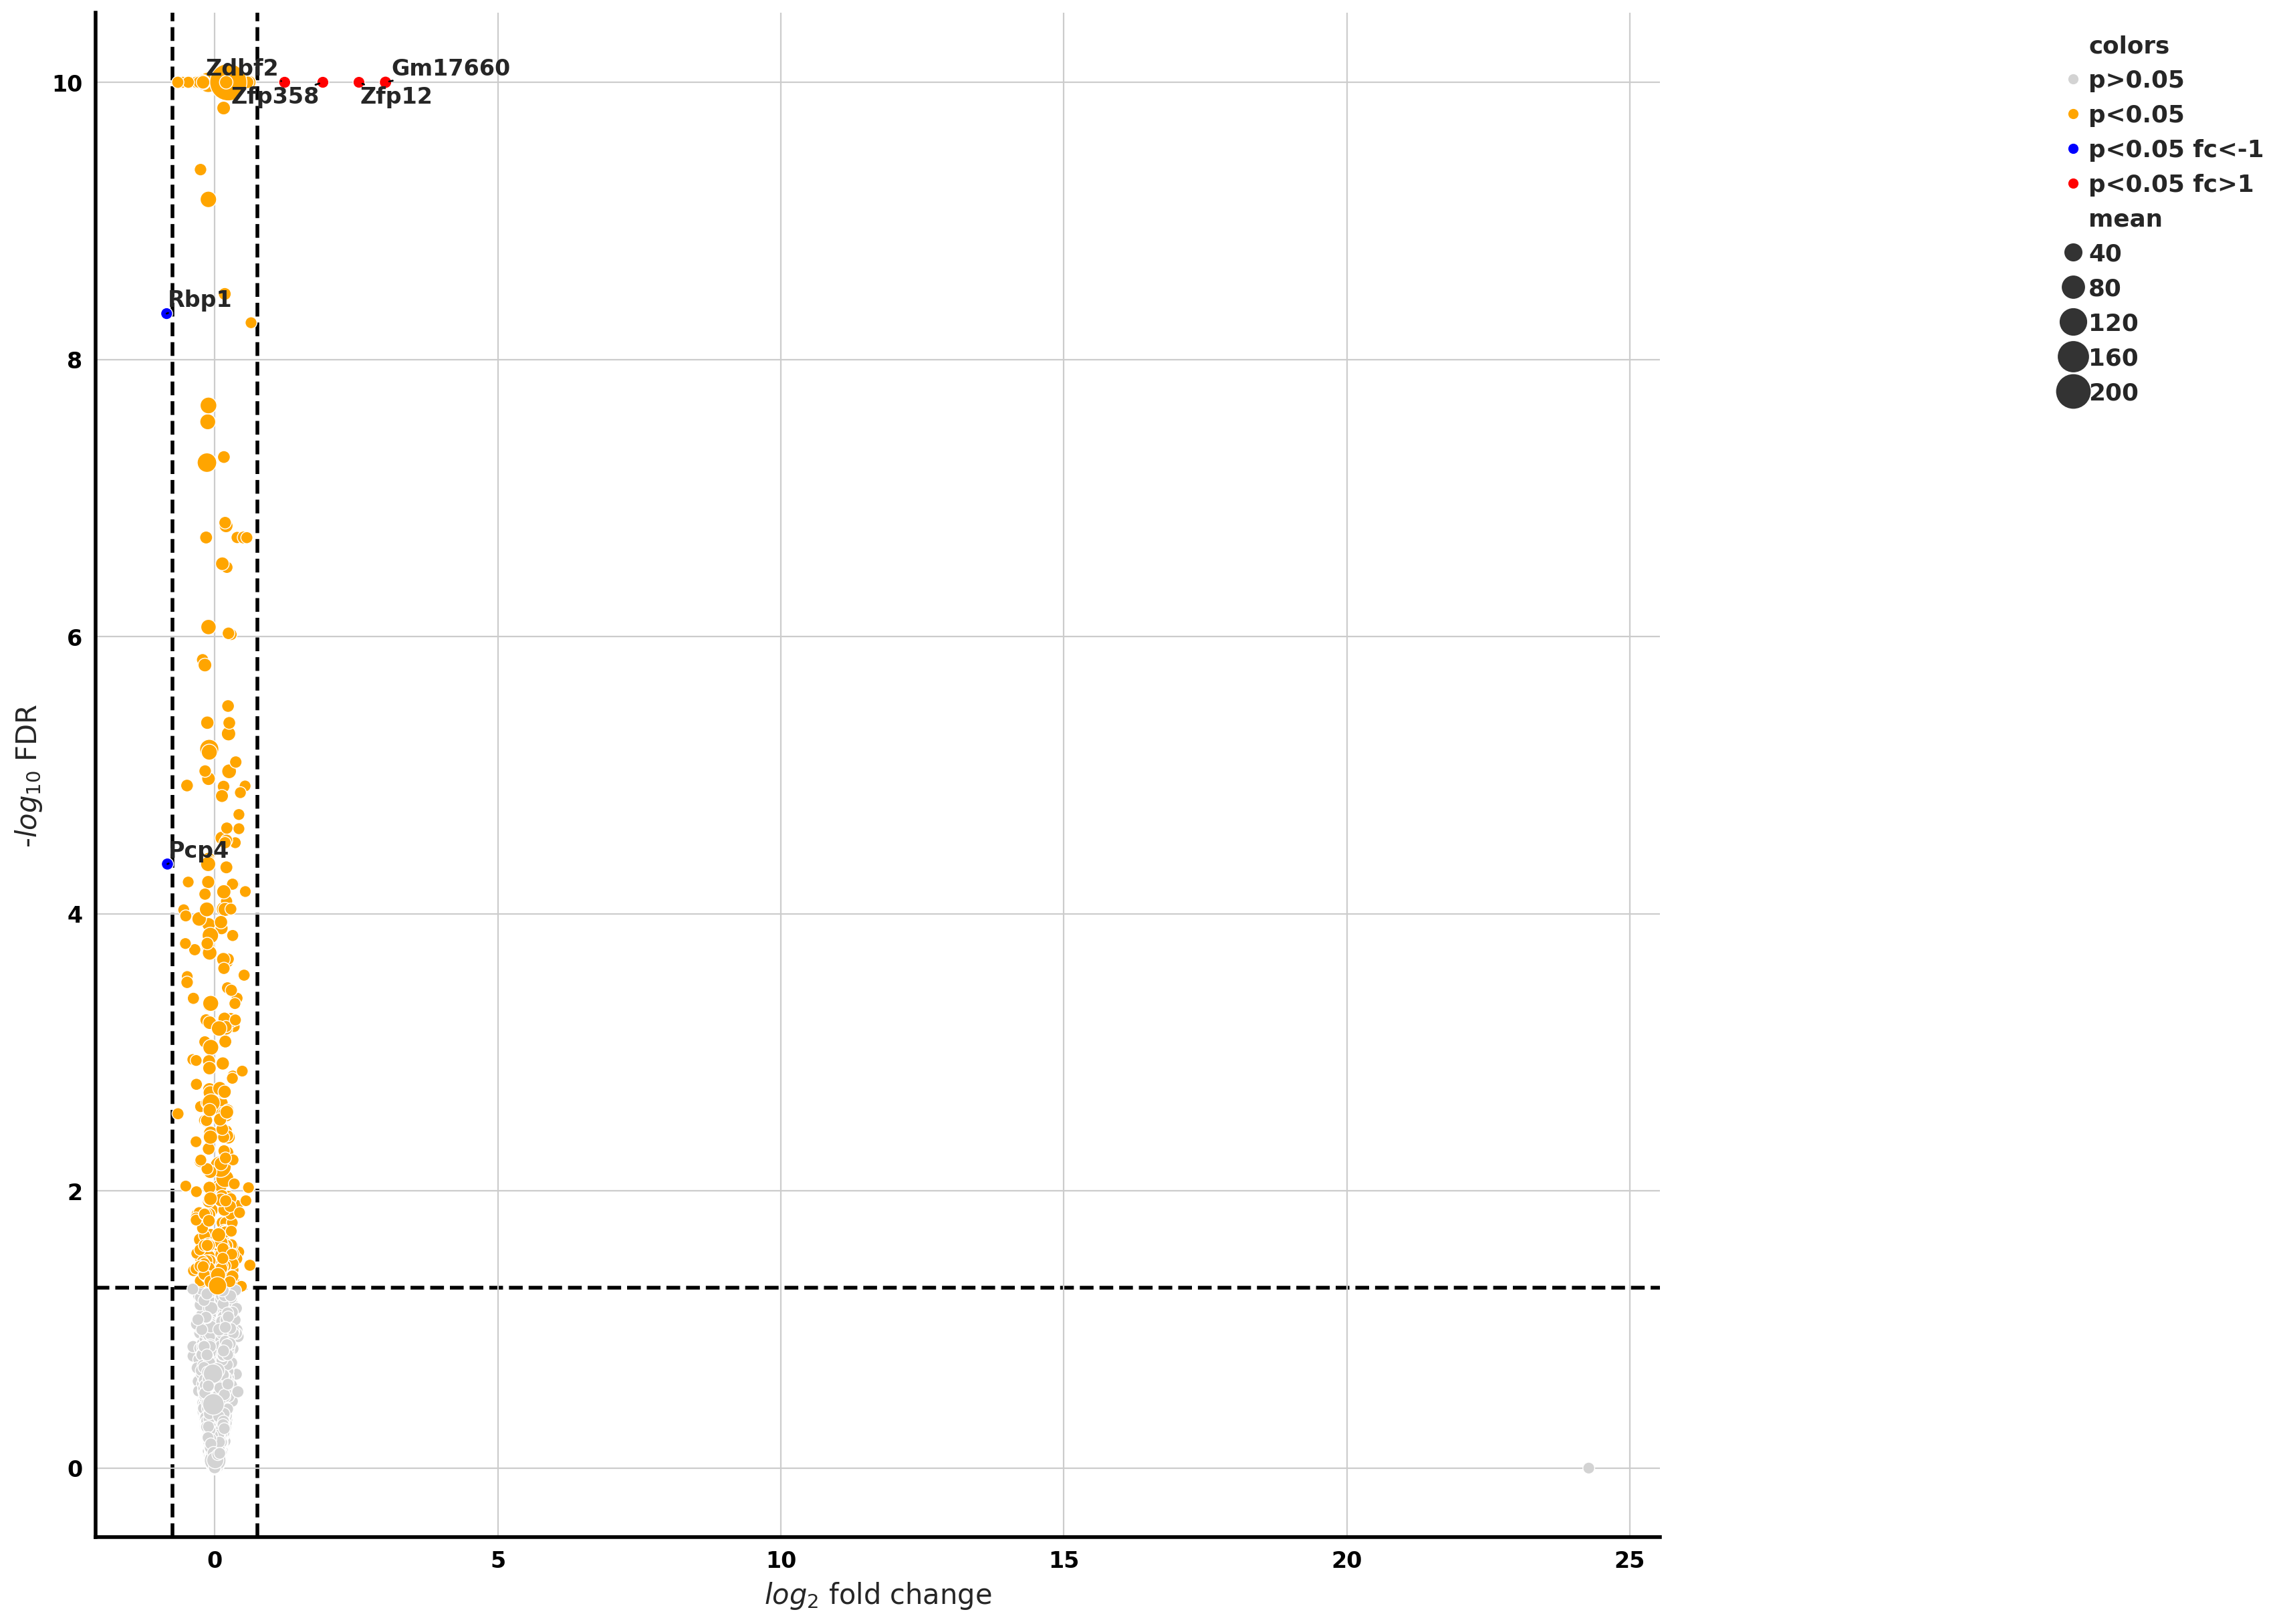

In [223]:
volcanoPlot(summary["PC.Foxp1"])

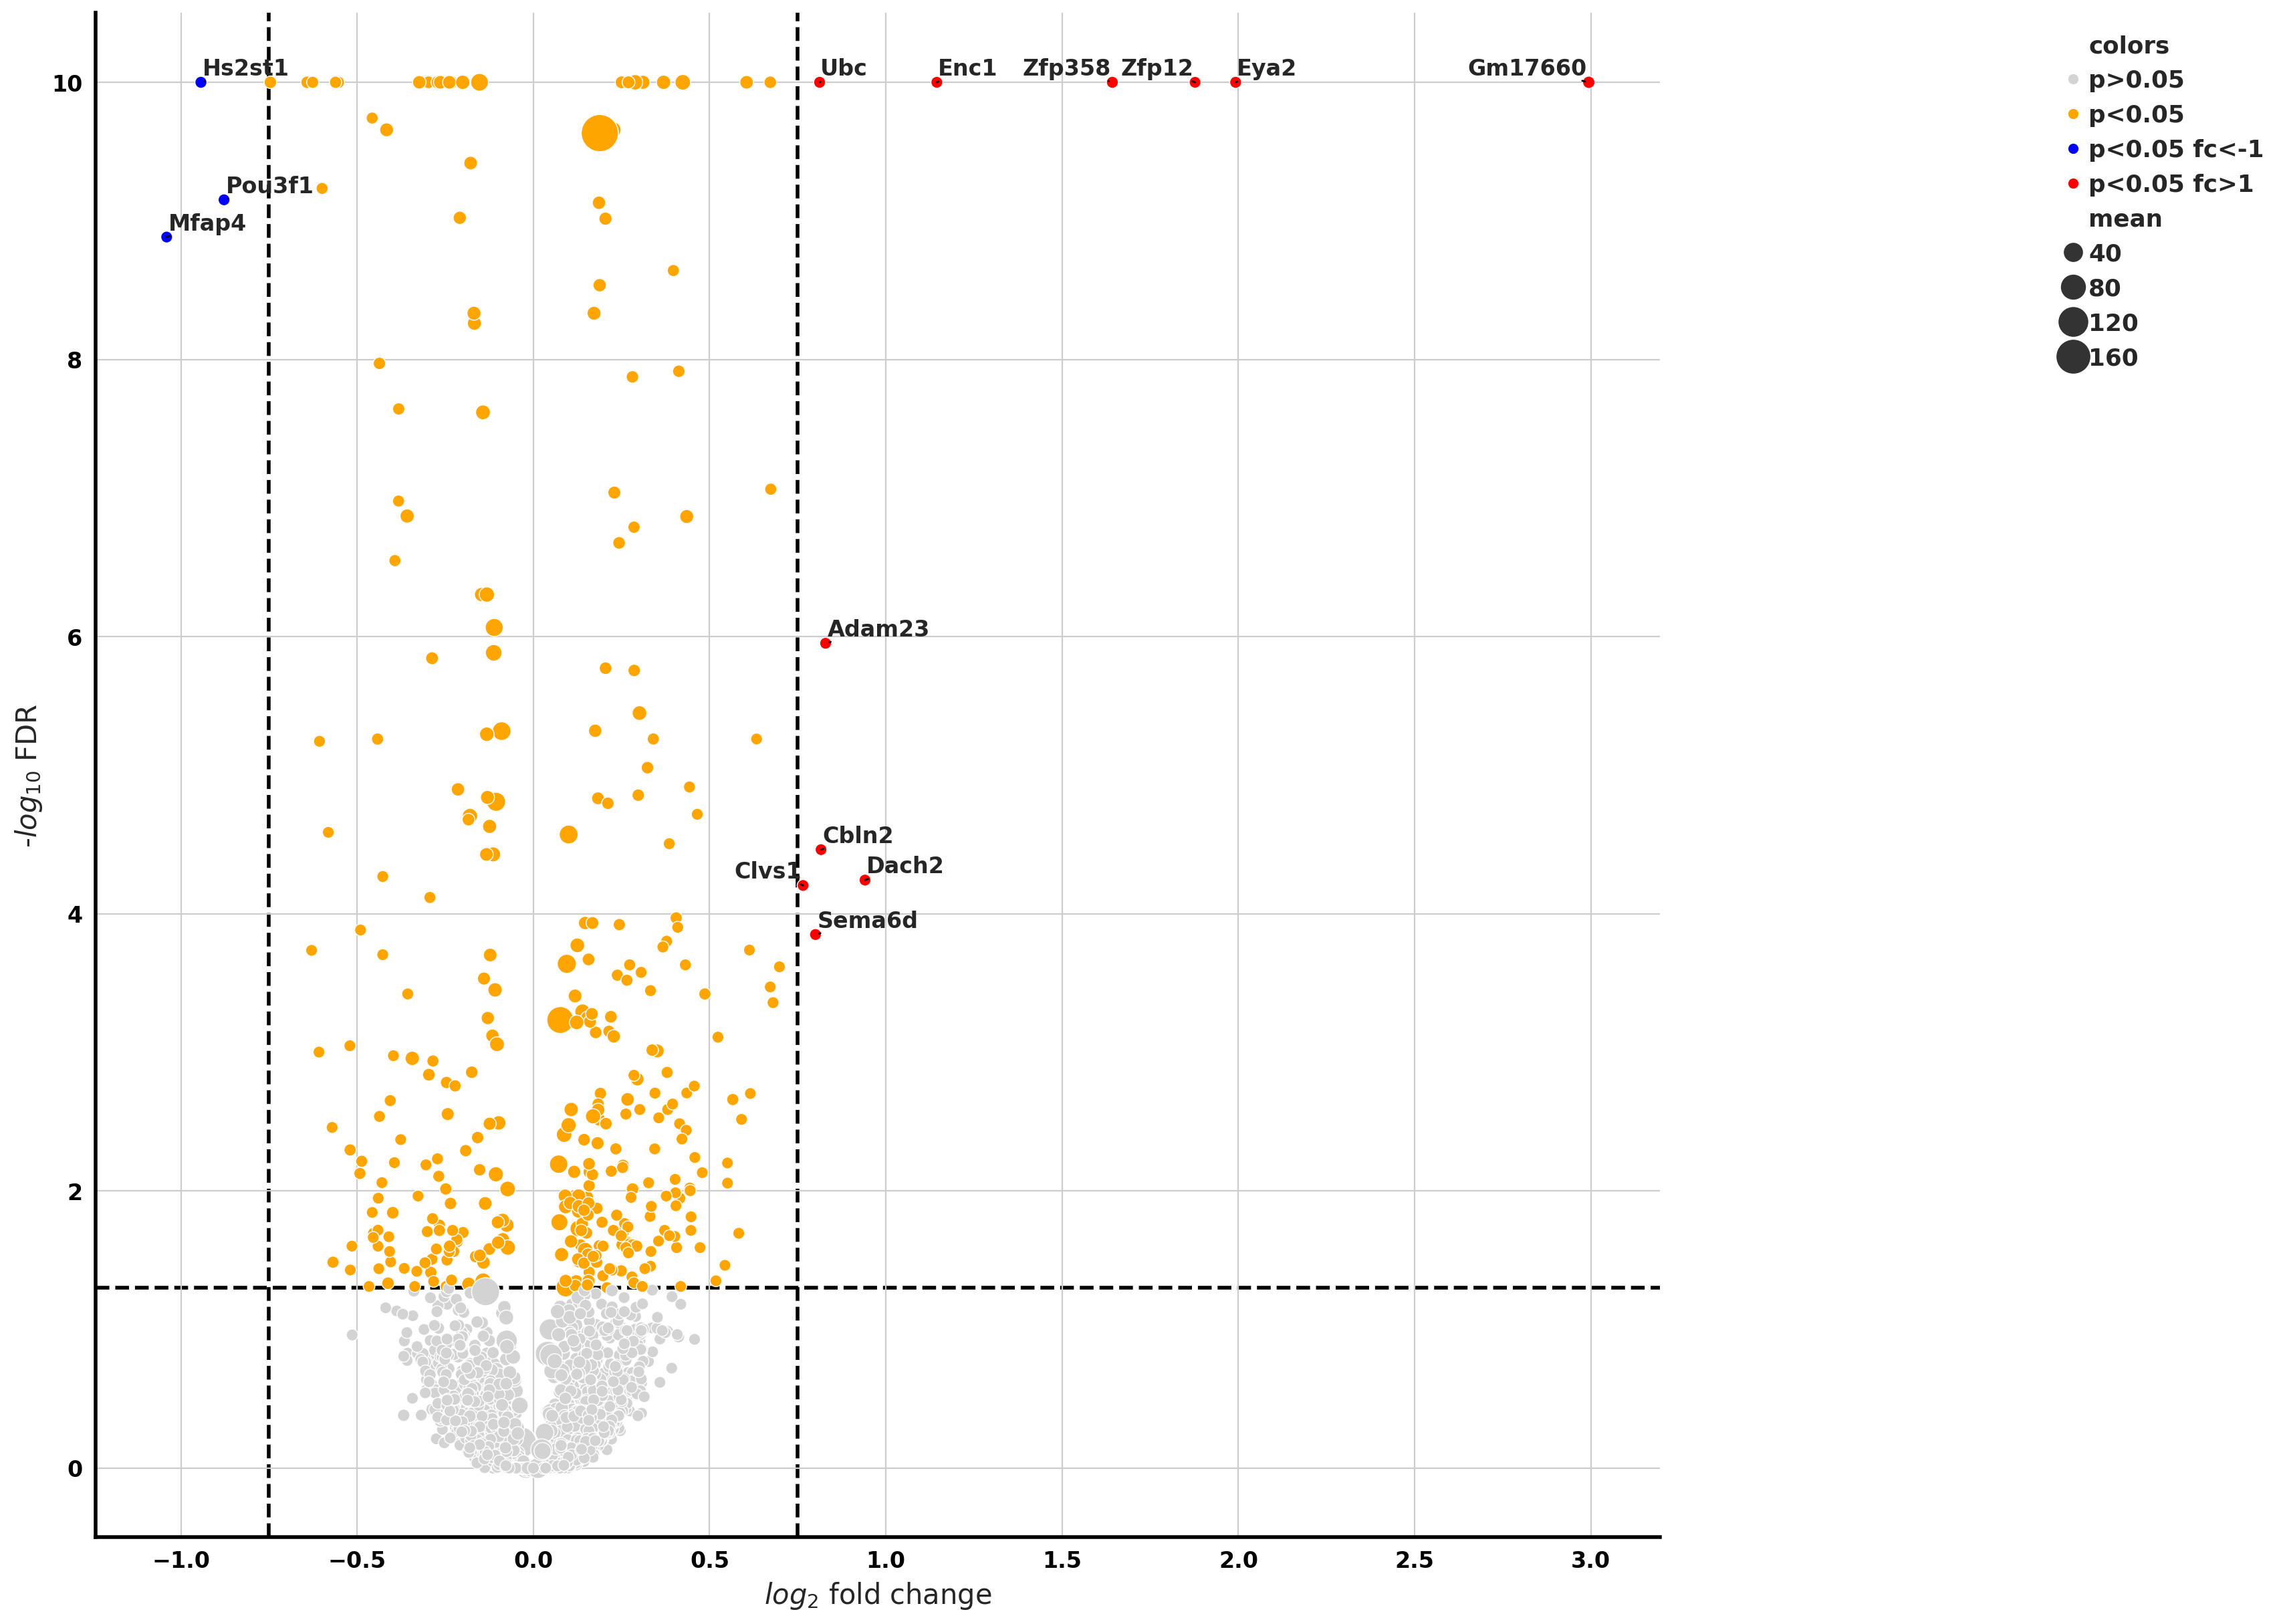

In [224]:
volcanoPlot(summary["GABA.Pro Ngrn+"])

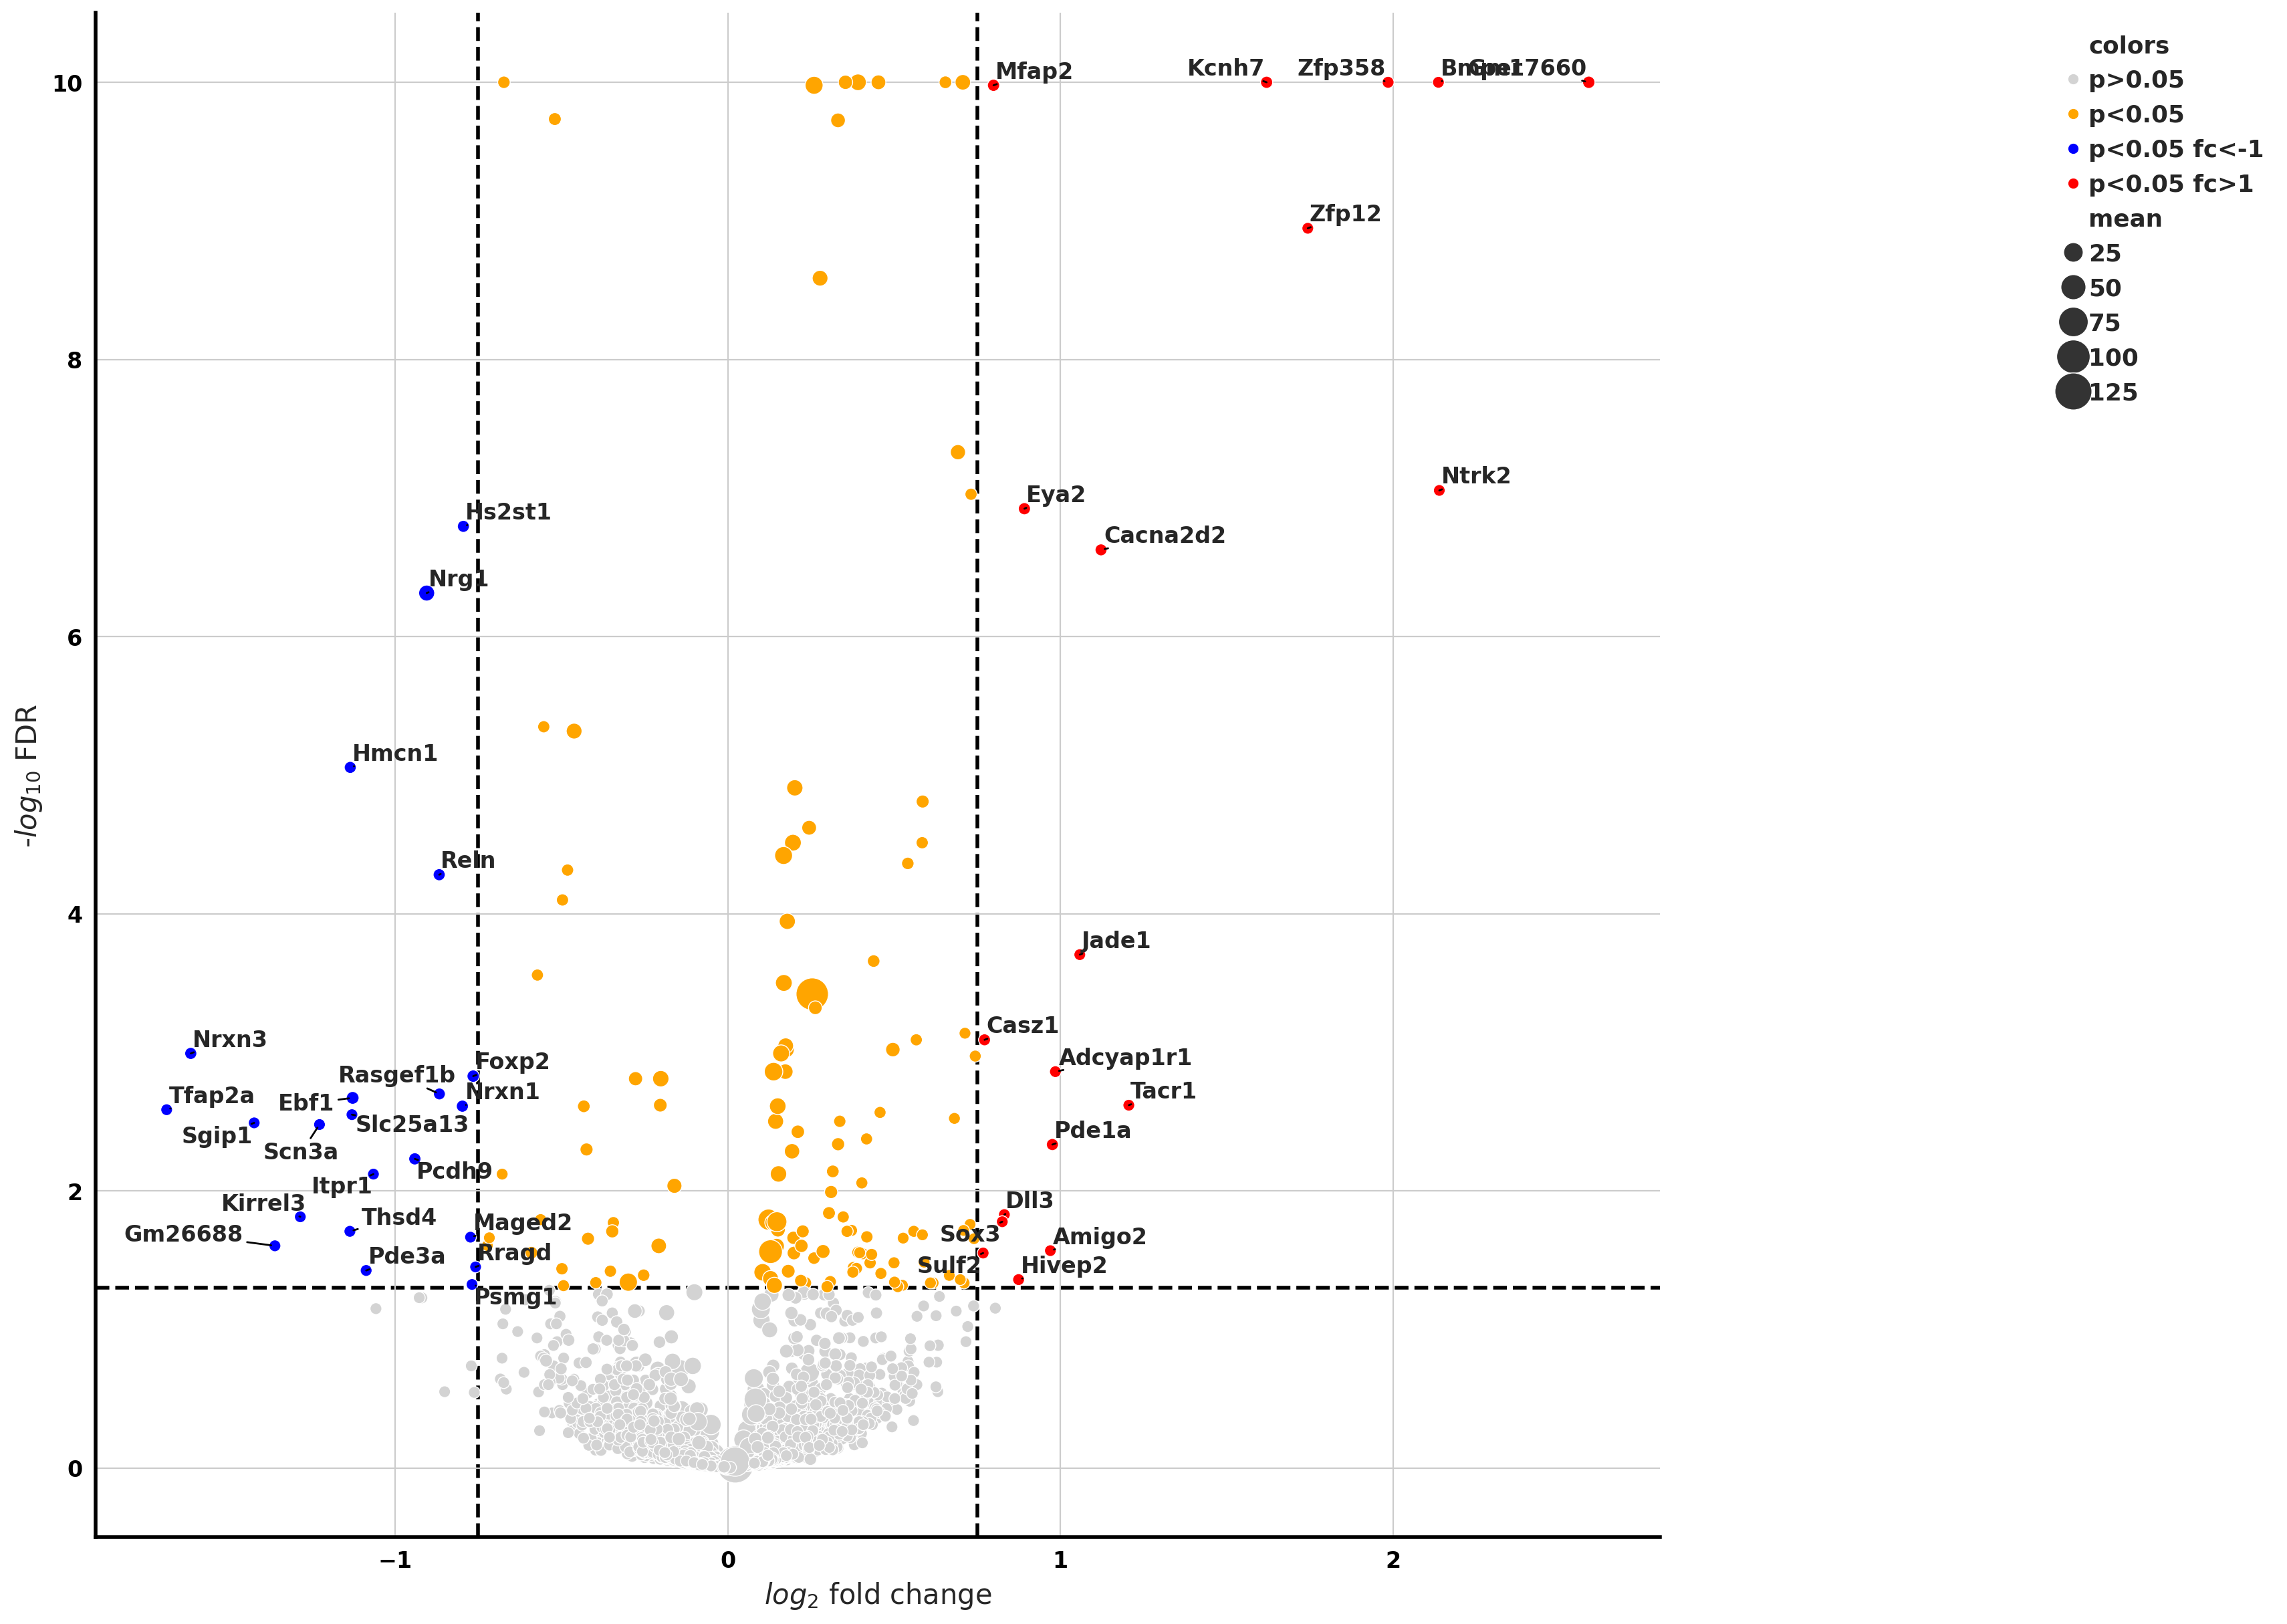

In [225]:
volcanoPlot(summary["GABA.Pro Ptf1a+"])

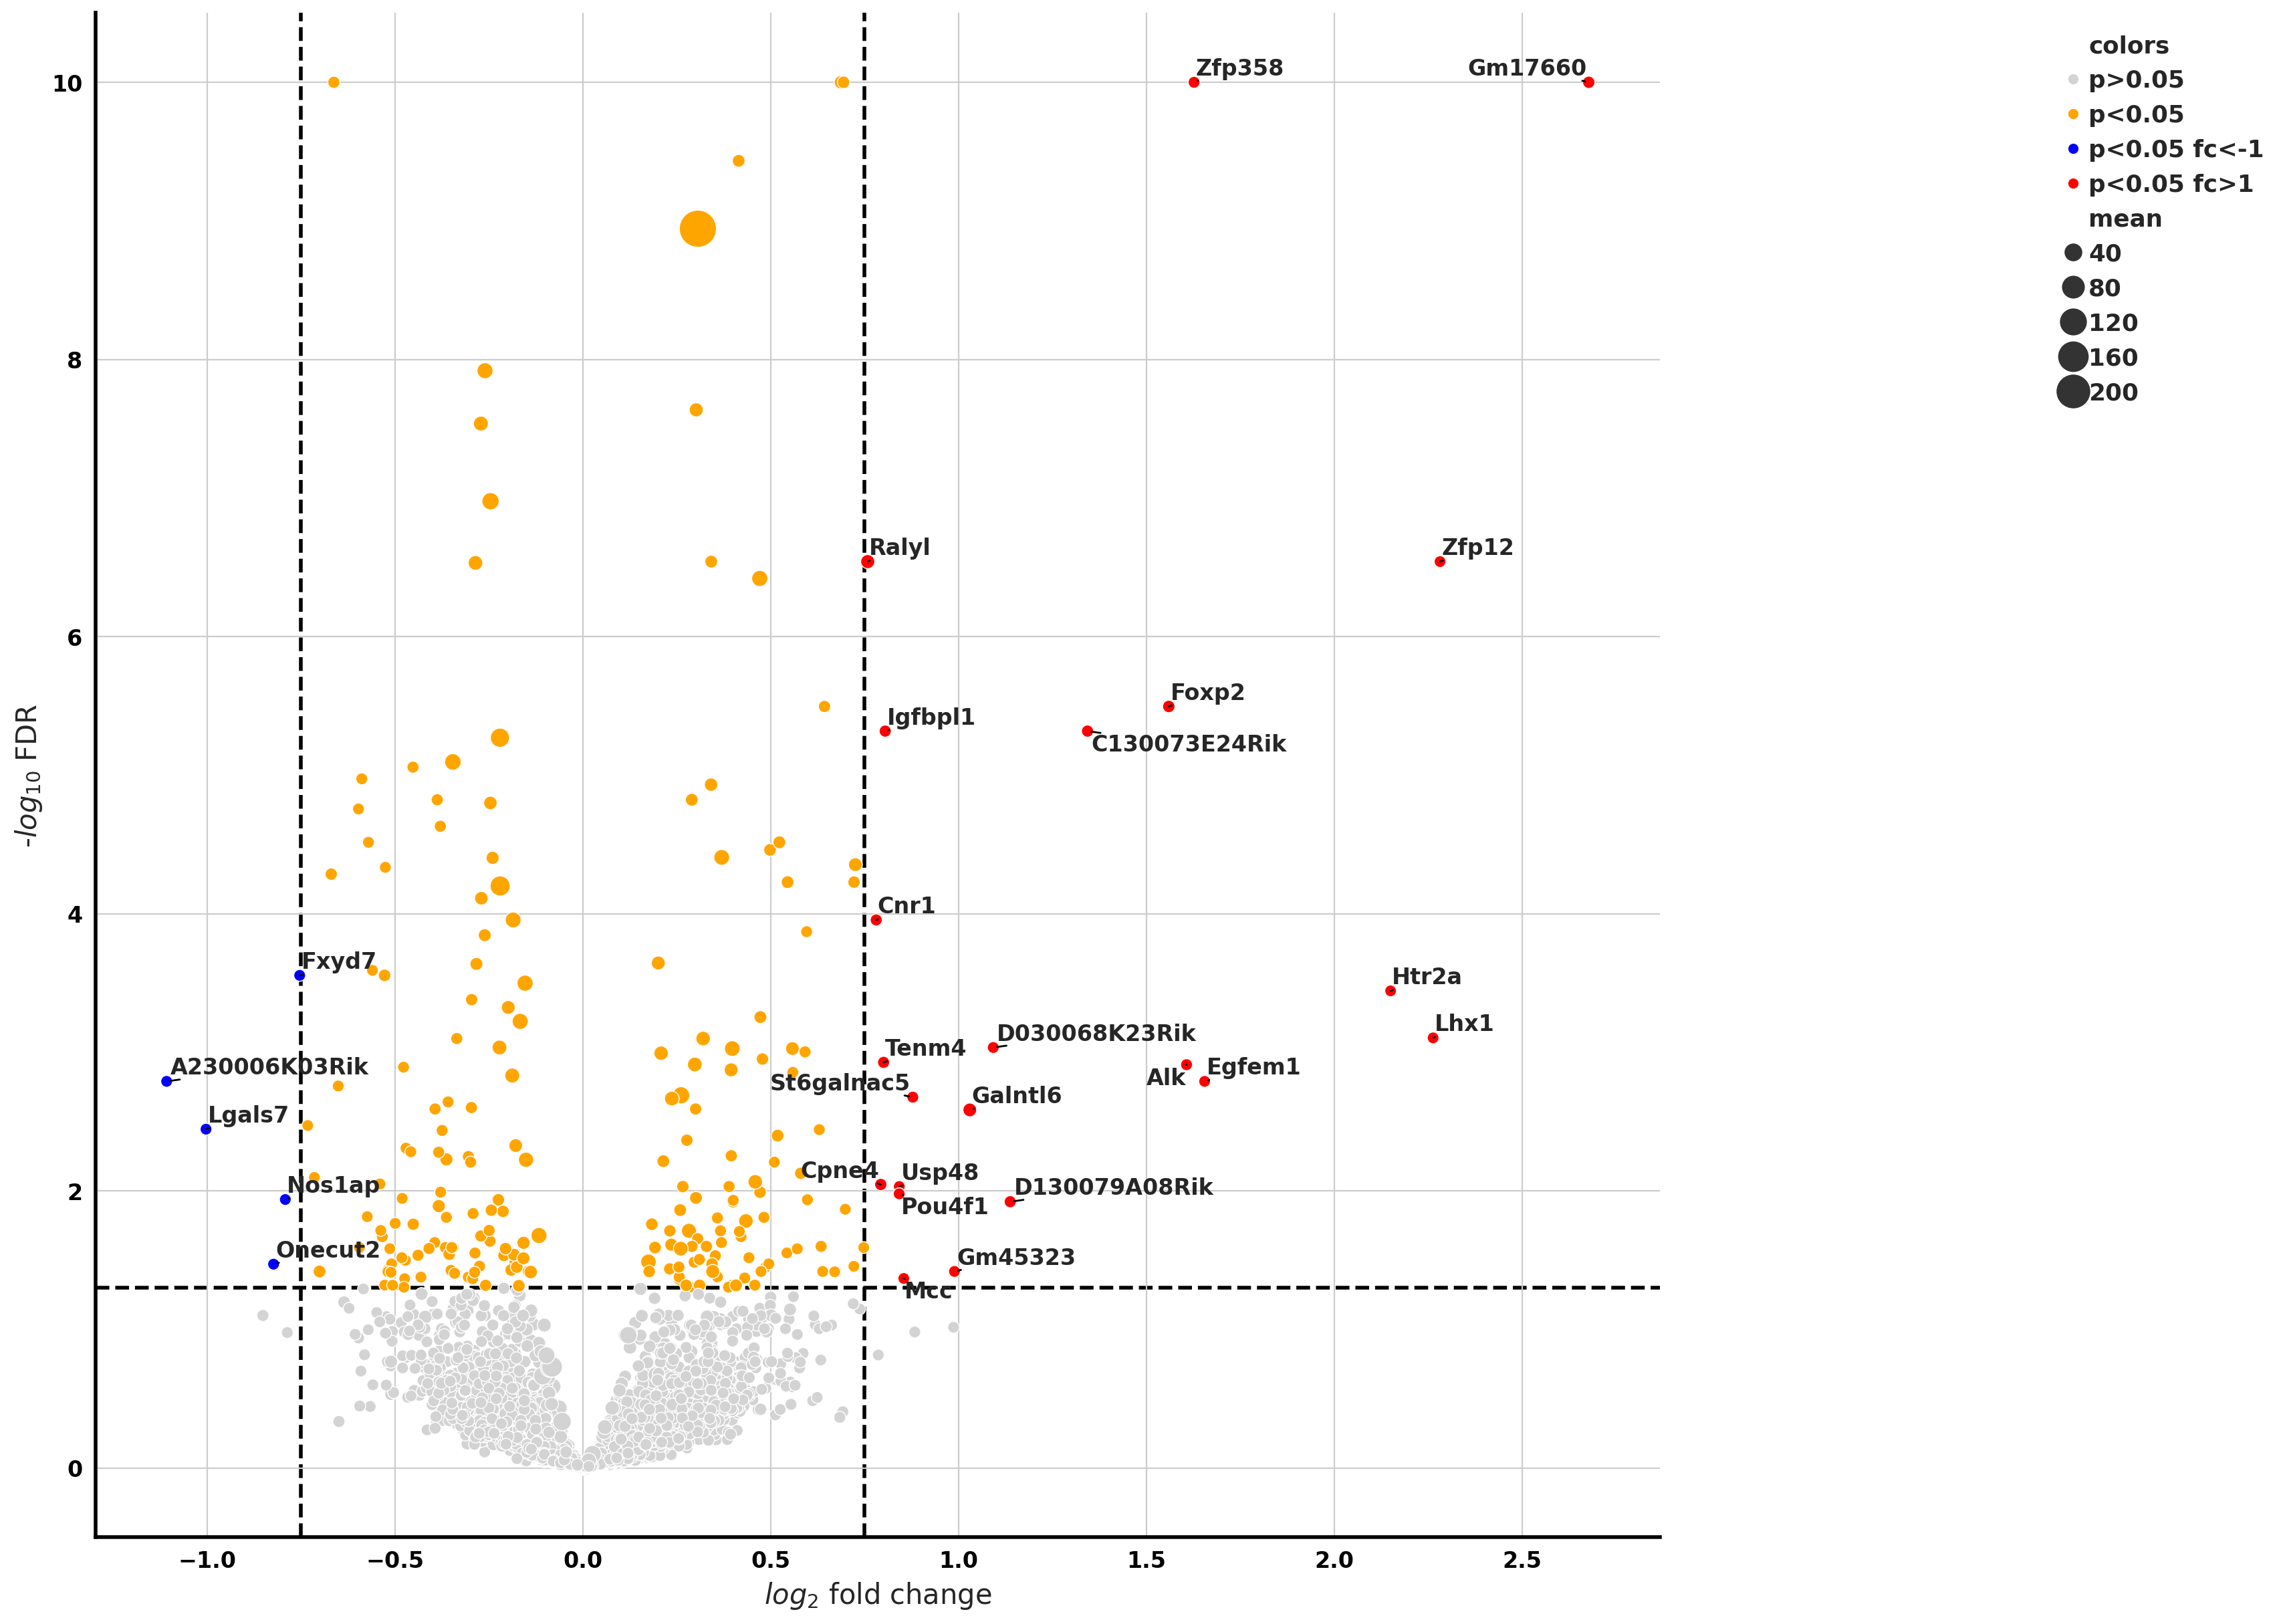

In [226]:
volcanoPlot(summary["Lmx1b+ Tlx3+"])

Write results to file

In [227]:
for cluster in summary.keys():
    summary[cluster].to_csv("".join(["analysis/diffExp/", cluster, "_WaldRes.csv"]))

### Gene-Set Enrichment Analysis

In [228]:
msig = Msigdb()
# mouse GOBP gene sets
geneSets = msig.get_gmt(category='m5.go.bp', dbver="2023.1.Mm")

/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/gseapy/msigdb.py:20: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]
/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/gseapy/msigdb.py:72: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  d = pd.read_html(resp.text)[0]


In [229]:
GSEAranks = {cluster: gseaPrep(summary[cluster]) for cluster in summary.keys()}
GSEA = {cluster: gp.prerank(rnk=GSEAranks[cluster],
                     gene_sets=geneSets,
                     threads=12,
                     min_size=15,
                     max_size=750,
                     permutation_num=50000, # reduce number to speed up testing
                     outdir="".join(["analysis/gsea/", cluster,"/"]), # write to disk
                     seed=SEED,
                     verbose=False 
                    ) for cluster in GSEAranks.keys()}

2024-01-15 18:15:33,940 [WARNING] Duplicated values found in preranked stats: 32.96% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-15 18:23:00,152 [WARNING] Duplicated values found in preranked stats: 20.74% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-15 18:29:17,777 [WARNING] Duplicated values found in preranked stats: 0.08% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-15 18:54:50,994 [WARNING] Duplicated values found in preranked stats: 0.13% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-15 19:01:17,549 [WARNING] Duplicated values found in preranked stats: 0.04% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2024-01-15 19:15:10,927 [WARNING] Duplicated values found in preranked stats: 1.86% of genes
The order of those genes will 

In [230]:
adata.write("analysis/objects/postDiffExp.h5ad")

## Pseudotime Analysis of the GABAergic Lineage

As our mutant gene is expressed along the GABAergic lineage, and most differentially expressed genes occur there, let's see how development of this lineage is affected by the mutation, using Pseudotime.

Select only cells which derive from the posterior VZ

In [ ]:
adataGABA = adata[~adata.obs["refinedCelltypes"].isin(["mCN", "lCN", "IsN", "C1", "Dlk1+", "PTZ", "MidO", "RL Pax6+", "RL Pax6-",  "RL2","Mes","Mes Dlk1+", "GC", "GC+RL", "Otp+ Prog", "Mes Isl1+ Tlx3+", "Pericyte", "Microglia", "Doublet", "Erythrocyte", "Myeloid Cells", "Endothelium", "Ascl1+ Ptf1a- Pro", "Pericyte"])]

### Lets re-run normalisation + PCA

Find deviant features using the R package scry

In [ ]:
#First convert some datatypes not accepted in R
adataGABA.obs.total_counts = adataGABA.obs.total_counts.astype(np.int32)
adataGABA.obs.total_counts_mt = adataGABA.obs.total_counts_mt.astype(np.int32)
adataGABA.obs.total_counts_ribo = adataGABA.obs.total_counts_ribo.astype(np.int32)
adataGABA.X = csr_matrix(adataGABA.X, dtype=np.float32)

In [ ]:
%%R
library(scry)

In [ ]:
#Save adataGABA object into our global environment
ro.globalenv["adataGABA"] = adataGABA

In [ ]:
%%R
sce = devianceFeatureSelection(adataGABA, assay="X")

In [ ]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

Sort the vector and select the top 2,000 highly deviant genes and save them as an additional column in .var as ‘highly_deviant’. We additionally save the computed binomial deviance in case we want to sub-select a different number of highly variable genes afterwards.

In [ ]:
idx = binomial_deviance.argsort()[-2000:]
mask = np.zeros(adataGABA.var_names.shape, dtype=bool)
mask[idx] = True

adataGABA.var["highly_deviant"] = mask
adataGABA.var["binomial_deviance"] = binomial_deviance

Normalise data and plot the variable genes

In [ ]:
adataGABA.layers["counts"] = adataGABA.X.copy() # preserve counts
sc.pp.normalize_total(adataGABA, target_sum=1e4) # scale each cell to a common library size
sc.pp.log1p(adataGABA) # log(expression + 1)
sc.pp.highly_variable_genes(adataGABA)

In [ ]:
adataGABA.obs["refinedCelltypes"].value_counts()

Plot dispersion versus mean for the genes and color by ‘highly_deviant’

In [ ]:
ax = sns.scatterplot(
    data=adataGABA.var, x="means", y="dispersions", hue="highly_deviant", s=5
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.show()

In [ ]:
adataGABA.var["highly_variable"] = adataGABA.var["highly_deviant"]
sc.tl.pca(adataGABA, svd_solver="arpack", use_highly_variable=True)
sc.pl.pca_variance_ratio(adataGABA, n_pcs=50)

In [30]:
from sklearn.metrics import silhouette_score,pairwise_distances
from sklearn.utils.extmath import randomized_svd
import scanpy as sc
import numpy as np
from scipy.spatial.distance import pdist,squareform
from igraph import Graph
import leidenalg as la
from sklearn.neighbors import KNeighborsTransformer
from sklearn.decomposition import TruncatedSVD
from multiprocess import Pool

def jaccardAdj(A, B):
    overlap = np.sum(((A == B) & (A != -1)))
    if overlap == 0: 
        return 0
    else:
        U = np.sum(((A != -1) & (B != -1)))
        jaccard = overlap / U
        return jaccard

def pairwise_jaccard(X):
    """Computes the number of times each row of `X` is 1 in the same column as every other row.
    """
    X = X.astype(bool).astype(int)
    intrsct = X.dot(X.T)
    return intrsct   

def conClus(scaledCounts, pcNum = 10, resRange=np.linspace(0.1,1, 10), bootSize = 0.8, bootNum = 100, kNum=20, threads = 1, seed = SEED, mode = "robust"):
            
        np.random.seed(seed)
        #Sample cells with replacement from adata
        boots = [np.random.choice(range(scaledCounts.shape[0]), int(scaledCounts.shape[0]*bootSize), replace=True) for boot in range(bootNum)]
        
        svd = TruncatedSVD(n_components=pcNum, n_iter=7, random_state=seed)  
        knnTranformer = KNeighborsTransformer(n_neighbors=kNum, metric='euclidean', algorithm='auto', n_jobs=1, mode="connectivity")
        # Cluster each bootstrap at different resolutions 
        # creating a pool object
        with Pool(processes=threads) as p:
            clustering = p.map(lambda boot: 
                   getClusAssignments(scaledCounts[boot],knnTranformer, boot, resRange, kNum, list(range(scaledCounts.shape[0])), svd, 
                                      seed=seed, mode=mode), boots)
        
        clustering = pd.concat( clustering, axis=1 )
        clustering = clustering.fillna(-1)
        
        knnTranformer = KNeighborsTransformer(n_neighbors=kNum, metric=jaccardAdj, n_jobs=threads, algorithm='auto', mode="connectivity")
        nbrs = knnTranformer.fit_transform(clustering)
        
        #Calculate snn adjacency between cells 
        snn = pairwise_jaccard(nbrs)
        # Create graph of number of shared neighbours between cells
        snnGraph = Graph.Weighted_Adjacency(snn, loops=False)
        
        #Cluster on shared neighbours graph
        clustering = {res: la.find_partition(snnGraph, la.RBConfigurationVertexPartition, resolution_parameter= res, seed=seed, weights = np.array(snnGraph.es["weight"]).astype(np.float64)).membership for res in resRange} 
        
        #Calculate silhouette score for each clustering resolution, 
        snn.data = kNum - snn.data #convert snn to a distance matrix
        clusterScores = {res: silhouette_score(snn, clustering[res], metric = "precomputed", random_state=seed) \
            if len(set(clustering[res])) > 1 else 0.2 for res in clustering.keys()}
        
        # Return clustering assignments at resolution with highest silhouette score
        assignments = [str(clust) for clust in clustering[max(clusterScores, key=clusterScores.get)]]
        
        return assignments

def getClusAssignments(scaledCounts, knnTranformer, boot, resRange, kNum, order, svd, seed, mode):
    
    nbrs = knnTranformer.fit_transform(svd.fit_transform(scaledCounts))
    snn = pairwise_jaccard(nbrs)
    snnGraph = Graph.Weighted_Adjacency(snn, loops=False)
    assignments = {str(res): la.find_partition(snnGraph, la.RBConfigurationVertexPartition, resolution_parameter = res, seed=seed, weights = np.array(snnGraph.es["weight"]).astype(np.float64)).membership for res in resRange}
    if mode == "robust":
        snn.data = kNum - snn.data
        clusterScores = {res: silhouette_score(snn, assignments[res], metric = "precomputed", random_state=seed) \
            if len(set(assignments[res])) > 1 else 0.2 for res in assignments.keys()}
        assignments = pd.DataFrame(assignments[max(clusterScores, key=clusterScores.get)])
    else:
        assignments = pd.DataFrame(assignments)
    assignments["cells"] = boot                  
    assignments = assignments.drop_duplicates(subset='cells', keep='first').set_index('cells').reindex(order)
    
    return assignments

In [10]:
svd = TruncatedSVD(n_components=10, n_iter=7, random_state=SEED)  
knnTranformer = KNeighborsTransformer(n_neighbors=20, metric='euclidean', algorithm='auto', n_jobs=1, mode="connectivity")

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
scaledCounts = sc.pp.scale(adata, copy=True)
scaledCounts = scaledCounts.X

/home/andy/bioinformatics/projects/DaniSC/code/analysis/scverse_venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [31]:
adata["consensus"] = conClus(scaledCounts, pcNum=10, bootNum = 500)
adata["consensusGranular"] = conClus(scaledCounts, pcNum=10, bootNum = 500, mode="granular")

ValueError: Object is view and cannot be accessed with `[]`.

In [ ]:
sc.pp.neighbors(adataGABA, n_pcs=5)
sc.tl.umap(adataGABA)

In [ ]:
sc.pl.umap(adataGABA, color=["refinedCelltypes"], ncols = 1)

In [ ]:
gb = adataGABA.obs.groupby(["refinedCelltypes", "ID"]).size()
counts = adataGABA.obs.groupby(["refinedCelltypes", "ID"]).size().to_frame('count')
counts['prop'] = gb / gb.groupby(level=1).sum()
counts = counts.reset_index().pivot(index='refinedCelltypes', columns='ID', values="prop")
counts["diff"] = ( counts["KO"] - counts["WT"] ) / counts["WT"] 
counts

In [ ]:
sc.tl.dendrogram(adataGABA, "refinedCelltypes")
gabaMarkers = {"aVZ": ["Msx3", "Hes5", "Hes1"],
               "pVZ": ["Mt3", "Luzp2"],
               "PTZ": ["Wnt1", "Cntnap2"],
               "MidO": ["Wls", "Rspo1", "Fgf17", "Calb2"],
               "Pro": ["Ptf1a","Tfap2b", "Prdm13", "Olig2"],
               "Tlx3": ["Dlk1", "Tlx3","Isl1", "Otp", "Lmx1b", "Lmx1a"],
               "Mature": ["Gad1", "Gad2"],
               "IN": ["Lbx1", "Pax2"],
               "PC": ["Rora", "Foxp2", "Etv1", "Nrgn", "En1", "Cck", "Foxp1", "Tle1", "Islr2"]
}
sc.pl.dotplot(adataGABA, gabaMarkers, groupby="refinedCelltypes", log=True, standard_scale="var", dendrogram=True)

In [ ]:
adataGABA.write("analysis/objects/adataGABA.h5ad")

### Infer the trajectory of cell states with slingshot

In [ ]:
#Save adata object of gabaergic cells into our global environment
ro.globalenv["adataGABA"] = adataGABA

In [ ]:
%%R
library(slingshot)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggprism)
library(matrixStats)

Restrict PCA to 5 dimensions

In [ ]:
%%R
reducedDim(adataGABA, "PCA_dim") = reducedDim(adataGABA, "PCA")[,1:5]

Run slingshot using known start and end points to aid trajectory inference

In [ ]:
%%R
sce <- slingshot(adataGABA, clusterLabels = 'refinedCelltypes', reducedDim = 'PCA_dim', start.clus = "VZ", end.clus = c("BG-like", "GABA.IN", "PC.Etv1", "PC.Foxp1", "Lmxb1+ Tlx3+"))

In [ ]:
%%R
SlingshotDataSet(sce)

In [ ]:
%%R
colData(sce)$refinedCelltypes = factor(colData(sce)$refinedCelltypes, levels = c("VZ", "BG-like", "GABA.Pro Ptf1a+", "GABA.Pro Tfap2b+",
                                                                                "GABA.Pro Ngrn+", "GABA.IN", "Lmxb1+ Tlx3+", "PC.Etv1", "PC.Foxp1"))
cols = ribiosPlot::fcbrewer(colData(sce)$refinedCelltypes, panel = RColorBrewer::brewer.pal(9, "Set1")[c(6,1,  2, 4, 5, 3, 7:9)])    
pca <- reducedDim(sce, "PCA")
jpeg(file="analysis/plots/trajectoryPlots/trajectoryplot.jpg", width=10, height=10, units="in", res=300)
# Add extra space to top of plot area; change clipping to figure
par(mar=c(4.1, 4.1, 10.1, 4.1), xpd=TRUE)
plot(pca, col = cols, asp = 1, pch = 16, xlab='PC1', ylab='PC2')
legend("top", legend = levels(colData(sce)$refinedCelltypes), pch = 16, col = unique(cols)[match(levels(colData(sce)$refinedCelltypes), unique(names(cols)))], cex=1.5, inset=c(0,-0.265), border = "black", box.col = "black", text.col = "black", horiz = F, x.intersp = 0.5, ncol = 2)
lines(SlingshotDataSet(sce), lwd=2, col=c("black","blue","red", "magenta", "grey"))
dev.off()

In [ ]:
%%R
##3D Plot 
cols = ribiosPlot::fcbrewer(colData(sce)$refinedCelltypes, panel = RColorBrewer::brewer.pal(9, "Set1")[c(6,1,  2, 4, 5, 3, 7:9)])                                            
library(rgl)
#graphics.off()
r3dDefaults$material$color <- "black"
r3dDefaults$material$lit <- FALSE
par3d(windowRect = c(20, 30, 1000, 1000))
rgl.viewpoint(zoom = 0.82,theta = 180)
rgl.bg( sphere = FALSE, fogtype = "none", color = c("white"),
back = "lines", fogScale = 1)

plot3d(pca,  alpha = 0.65, size = 5, col = cols, xlab='PC1', ylab='PC2', zlab='PC3')

legend3d("top", legend = levels(colData(sce)$refinedCelltypes), pch = 16, col = unique(cols)[c(3, 9, 6, 8, 1, 5, 7, 2, 4)], cex=2, inset=c(0,0.05), bg.color = "white", border = "black", box.col = "black", text.col = "black", horiz = F, x.intersp = 0.5, ncol = 2)

plot3d.SlingshotDataSet(sce, type = "curves", lwd = 5, add = TRUE, col = c("black","blue","red", "magenta", "grey"))

# capture snapshot
snapshot3d(filename = "analysis/plots/trajectoryPlots/3Dtrajectoryplot.png", fmt = 'png')

In [ ]:
%%R
psts <- slingPseudotime(sce) %>%
  as.data.frame() %>%
  mutate(cells = rownames(.),
         conditions = sce$ID) %>%
  pivot_longer(starts_with("Lineage"), values_to = "pseudotime", names_to = "lineages")

In [ ]:
%%R
ggplot(psts, aes(x = pseudotime, fill = conditions)) +
  geom_density(alpha = 0.75) +
  scale_fill_brewer(type = "qual") +
  facet_wrap(~lineages) +
  theme(legend.position = "bottom") + theme_prism()
ggsave(file = paste0("analysis/plots/trajectoryPlots/trajDistributions.jpg"))

In [ ]:
%%R
########################
### Kolmogorov-Smirnov Test Lineage 2 (Tlx3+)
########################
ks.test(slingPseudotime(sce)[colData(sce)$ID == "KO", 3],
        slingPseudotime(sce)[colData(sce)$ID == "WT", 3])

In [ ]:
%%R
########################
### Kolmogorov-Smirnov Test Lineage 3 (IN)
########################
ks.test(slingPseudotime(sce)[colData(sce)$ID == "KO", 4],
        slingPseudotime(sce)[colData(sce)$ID == "WT", 4])

Save slingshot object

In [ ]:
%%R
saveRDS(sce, file = "analysis/objects/gabaSlingshot.rds")

## Assess differential gene expression along lineages between conditions using tradeseq

In [3]:
%%R
library(slingshot)
library(SingleCellExperiment)
library(RColorBrewer)
library(scales)
library(viridis)
library(UpSetR)
library(pheatmap)
library(knitr)
library(ggplot2)
library(gridExtra)
library(tradeSeq)
library(clusterExperiment)
library(gridExtra)
library(clusterProfiler)

Loading required package: princurve
Loading required package: TrajectoryUtils
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps

Let's use multiple cores 

In [4]:
%%R
BPPARAM <- BiocParallel::bpparam()
BPPARAM$workers = 6 # use multiple cores

In [ ]:
%%R
sce = readRDS("analysis/objects/gabaSlingshot.rds")

And filter to just the top 8000 most deviant genes

In [ ]:
%%R
sce = sce[rownames(sce) %in% rownames(rowData(sce)[order(rowData(sce)$binomial_deviance, decreasing = T),])[1:8000],]

Select number of knots for trade-seq

In [ ]:
%%R
SEED=123
set.seed(SEED)
icMat <- evaluateK(sce,
                   conditions = factor(colData(sce)$ID),
                   nGenes = 300,
                   k = 3:10, parallel = T, BPPARAM = BPPARAM)

Fit the GAM

In [ ]:
%%R
set.seed(SEED)
sce <- fitGAM(sce, conditions = factor(colData(sce)$ID),
              nknots = 6, parallel = T, BPPARAM = BPPARAM, verbose = F)
mean(rowData(sce)$tradeSeq$converged)

Save tradeseq object

In [ ]:
%%R
saveRDS(sce, file = "analysis/objects/gabaTradeSeq.rds")

#### Assess DE along pseudotime

Find genes whose expression changes along pseudotime by lineage

In [ ]:
%%R
sce = readRDS("analysis/objects/gabaTradeSeq.rds")

In [ ]:
%%R
rowData(sce)$assocRes <- associationTest(sce, lineages = TRUE, l2fc = log2(2))

In [ ]:
assocRes = ro.r("rowData(sce)$assocRes")
assocRes

In [ ]:
%%R
gene = "Olig2"
plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#581845", "#031955", "#FFC300", "#ff00c5", "#FF5733", "#b900ff", "#C70039", "#0046ff", "#890202", "#3a00ff")) + ggplot2::scale_colour_manual(values =c("#581845", "#031955", "#FFC300", "#ff00c5", "#FF5733", "#b900ff", "#C70039", "#0046ff", "#890202", "#3a00ff"))

Compare the numbers of significantly changing genes between KO and WT

In [ ]:
%%R
assocRes <- rowData(sce)$assocRes
KOgenes <-  rownames(assocRes)[
  which(p.adjust(assocRes$pvalue_lineage3_conditionKO, "fdr") <= 0.05)
]
WTgenes <-  rownames(assocRes)[
  which(p.adjust(assocRes$pvalue_lineage3_conditionWT, "fdr") <= 0.05)
]

print( paste(length(KOgenes) , length(WTgenes)) )

In [ ]:
%%R
UpSetR::upset(fromList(list(KO = KOgenes, WT = WTgenes)))

Directly compare gene changes along pseudotime in KO vs WT

In [ ]:
%%R
plotGeneCount(curve = sce, counts = counts,
              clusters = apply(slingClusterLabels(sce), 1, which.max),
              models = sce)

In [ ]:
%%R
rowData(sce)$condRes <- conditionTest(sce, l2fc = log2(1.5), lineages = T, knots=c(2,4))
rowData(sce)$condRes$padj <- p.adjust(rowData(sce)$condRes$pvalue, "fdr")
for(lineage in c(1:5)){
    rowData(sce)$condRes[,paste0("padj_lineage", lineage)]  <- p.adjust(rowData(sce)$condRes[,paste0("pvalue_lineage", lineage)], "fdr")
}

In [234]:
condRes = ro.r("rowData(sce)$condRes")
condRes

,waldStat,df,pvalue,waldStat_lineage1,df_lineage1,pvalue_lineage1,waldStat_lineage2,df_lineage2,pvalue_lineage2,waldStat_lineage3,...,pvalue_lineage4,waldStat_lineage5,df_lineage5,pvalue_lineage5,padj,padj_lineage1,padj_lineage2,padj_lineage3,padj_lineage4,padj_lineage5
Xkr4,0.237331,2.0,0.888105,21.678214,3.0,0.000076,16.233024,3.0,0.001016,30.371511,...,0.053132,0.237331,2.0,0.888105,1.0,0.030208,0.201792,0.000655,1.0,1.0
Mrpl15,0.026058,8.0,1.000000,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.026058,2.0,0.987056,1.0,1.000000,1.000000,1.000000,1.0,1.0
Lypla1,0.695813,4.0,0.951844,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.695813,2.0,0.706165,1.0,1.000000,1.000000,1.000000,1.0,1.0
Tcea1,0.000000,5.0,1.000000,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.000000,2.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
Rgs20,0.156612,2.0,0.924682,0.370505,3.0,0.946266,0.000000,3.0,1.000000,0.296005,...,0.945725,0.156612,2.0,0.924682,1.0,1.000000,1.000000,1.000000,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
mt-Cytb,0.000000,2.0,1.000000,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.000000,2.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
CAAA01118383.1,0.148026,8.0,0.999999,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.148026,2.0,0.928660,1.0,1.000000,1.000000,1.000000,1.0,1.0
Vamp7,0.000000,8.0,1.000000,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.000000,...,1.000000,0.000000,2.0,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0
Tmlhe,0.056295,2.0,0.972245,0.000000,3.0,1.000000,0.000000,3.0,1.000000,0.006195,...,1.000000,0.056295,2.0,0.972245,1.0,1.000000,1.000000,1.000000,1.0,1.0


In [ ]:
%%R
condResGSEA <- enrichGO(gene          = rownames(rowData(sce)$condRes[rowData(sce)$condRes$padj_lineage2 < 0.05,]),
                universe      = rownames(rowData(sce)$condRes),
                OrgDb         = org.Mm.eg.db,
                ont           = "BP",
                pAdjustMethod = "BH",
                pvalueCutoff  = 0.01,
                qvalueCutoff  = 0.05,
        readable      = TRUE)

In [ ]:
condResGSEA = ro.r("condResGSEA")
condResGSEA

Plot some interesting genes

In [10]:
condRes[condRes.index.isin(["Pax3", "Pax2", "Olig2", "Olig3" , "Prdm13", "Ptf1a", "Ascl1", "Lmx1b"])]

,waldStat,df,pvalue,waldStat_lineage1,df_lineage1,pvalue_lineage1,waldStat_lineage2,df_lineage2,pvalue_lineage2,waldStat_lineage3,...,pvalue_lineage4,waldStat_lineage5,df_lineage5,pvalue_lineage5,padj,padj_lineage1,padj_lineage2,padj_lineage3,padj_lineage4,padj_lineage5
Pax3,1.789154,3.0,0.617298,1.000353,3.0,0.801166,0.000000,3.0,1.000000e+00,0.723776,...,4.122485e-01,NaN,NaN,NaN,1.0,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN
Ptf1a,3.216923,6.0,0.781170,6.118095,3.0,0.106004,9.009660,3.0,2.916272e-02,7.054922,...,2.300597e-03,0.295946,2.0,0.862455,1.0,1.000000,1.000000e+00,1.000000,5.223671e-01,1.0
Lmx1b,10.352209,5.0,0.065849,11.474026,3.0,0.009420,53.700139,3.0,1.300060e-11,32.011164,...,2.955076e-05,0.124734,2.0,0.939538,1.0,1.000000,1.033028e-08,0.000345,1.467749e-02,1.0
Prdm13,1.262495,2.0,0.531928,21.355189,3.0,0.000089,36.686911,3.0,5.359473e-08,6.126570,...,4.762968e-12,NaN,NaN,NaN,1.0,0.033581,2.839091e-05,1.000000,4.731413e-09,NaN
Olig3,5.110737,2.0,0.077664,0.000000,3.0,1.000000,0.003748,3.0,9.999390e-01,1.897266,...,3.004698e-01,5.110737,2.0,0.077664,1.0,1.000000,1.000000e+00,1.000000,1.000000e+00,1.0
Ascl1,5.737860,4.0,0.219599,1.520061,2.0,0.467652,3.253228,3.0,3.542057e-01,2.274114,...,1.000000e+00,NaN,NaN,NaN,1.0,1.000000,1.000000e+00,1.000000,1.000000e+00,NaN
Olig2,0.090214,2.0,0.955895,12.473894,3.0,0.005924,25.213892,3.0,1.392942e-05,11.154190,...,2.247401e-03,0.090214,2.0,0.955895,1.0,0.979834,4.257045e-03,1.000000,5.223671e-01,1.0
Pax2,4.553568,4.0,0.336243,6.853867,3.0,0.076704,12.103427,3.0,7.037133e-03,9.290440,...,1.785353e-02,0.021974,2.0,0.989073,1.0,1.000000,9.640872e-01,1.000000,1.000000e+00,1.0


In [ ]:
%%R
gene = "Asic2"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Nckap5"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Olig2"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Olig3"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Pax3"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Pax2"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Ptf1a"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Lmx1b"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Ascl1"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Prdm13"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Tfap2b"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
gene = "Tlx3"
plt = plotSmoothers(sce, assays(sce)$counts, gene = gene, alpha = 1, border = TRUE, curvesCol=c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955")) + ggplot2::scale_colour_manual(values =c("#FFC300", "#ff00c5", "#ff5a00", "#b900ff", "#ff0000", "#0046ff", "#ad0000", "#3a00ff", "#581845","#031955"))
ggsave(plt, file = paste0("analysis/plots/trajectoryPlots/", gene, ".jpg"))
plt

In [ ]:
%%R
saveRDS(sce, file = "analysis/objects/gabaTradeSeq.rds")

## Predicting Prdm13 targets with random forrest regression

Lineage 2

In [4]:
%%R
sce = readRDS("analysis/objects/gabaTradeSeq.rds")

In [6]:
%%R
# Function to take mean of values in sparse matrix by bins
sum_by_bins_sparse <- function(data, pseudotime, lineage, nbins=100, tradeSeq=F, goi) {
  if (!is.numeric(pseudotime)) {
    stop("Numeric pseudotime vector is required.")
  }
  if (!is.numeric(nbins)) {
    stop("Bin number required")
  }
  
  if(tradeSeq){
    ptData = predictSmooth(data, c(rownames(data)[!rownames(data) == goi], goi), nPoints = nbins, tidy = F)
    goiWT = ptData[nrow(ptData),1:100]
    ptData = ptData[, 101:200]-ptData[,1:100]
    ptData = as.data.frame(rbind(ptData, goiWT))
    rownames(ptData) = c(rownames(data), paste0(goi, "WT"))
  } else {
      bins = quantile(pseudotime, probs = seq(0, 1, length.out = nbins+1),na.rm=T)
      ptData = purrr::map(c(2:length(bins)), function(binNum){
        bin=((pseudotime > bins[binNum-1]) & (pseudotime < bins[binNum]))
        bin[is.na(bin)] = FALSE
        Matrix::rowMeans(data[,bin], na.rm=T) 
        } ) 
       ptData=t(do.call(rbind.data.frame, ptData))
       rownames(ptData) = rownames(data)
  }
  
  return(ptData)
}

Lets partition data into train and test cells, and seperately fit tradeseq models to these (to prevent data leakage)

In [105]:
%%R
library(scuttle)
sce = logNormCounts(sce)
train.index <- caret::createDataPartition(assays(sce)$logcounts[rownames(assays(sce)$logcounts) == "Prdm13",], p = .7, list = FALSE)
train <- sce[, train.index]
test  <- sce[,-train.index]
p3SnoothedWT = sum_by_bins_sparse(assays(sce)$logcounts[(rowData(sce)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(sce)$condRes$pvalue_lineage2), colData(sce)$ID == "WT"], colData(sce)$slingPseudotime_2[colData(sce)$ID == "WT"], 100)
p3SnoothedKO = sum_by_bins_sparse(assays(sce)$logcounts[(rowData(sce)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(sce)$condRes$pvalue_lineage2), colData(sce)$ID == "KO"], colData(sce)$slingPseudotime_2[colData(sce)$ID == "KO"], 100)
p3SnoothedWT_train = sum_by_bins_sparse(assays(train)$logcounts[(rowData(train)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(train)$condRes$pvalue_lineage2), colData(train)$ID == "WT"], colData(train)$slingPseudotime_2[colData(train)$ID == "WT"], 100)
p3SnoothedWT_test = sum_by_bins_sparse(assays(test)$logcounts[(rowData(test)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(test)$condRes$pvalue_lineage2), colData(test)$ID == "WT"], colData(test)$slingPseudotime_2[colData(test)$ID == "WT"], 30)
p3SnoothedKO_train = sum_by_bins_sparse(assays(train)$logcounts[(rowData(train)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(train)$condRes$pvalue_lineage2), colData(train)$ID == "KO"], colData(train)$slingPseudotime_2[colData(train)$ID == "KO"], 100)
p3SnoothedKO_test = sum_by_bins_sparse(assays(test)$logcounts[(rowData(test)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(test)$condRes$pvalue_lineage2), colData(test)$ID == "KO"], colData(test)$slingPseudotime_2[colData(test)$ID == "KO"], 30)

In [106]:
%%R 
X = as.data.frame(t(p3SnoothedKO - p3SnoothedWT))
y = p3SnoothedWT["Prdm13",]
X_train = as.data.frame(t(p3SnoothedKO_train - p3SnoothedWT_train))
y_train = p3SnoothedWT_train["Prdm13",]
X_test = as.data.frame(t(p3SnoothedKO_test - p3SnoothedWT_test))
y_test = p3SnoothedWT_test["Prdm13",]

Try with tradeseq

In [33]:
%%R
sce = scuttle::logNormCounts(sce)
data = sce[(rowData(sce)$condRes$pvalue_lineage2 < 0.05) & !is.na(rowData(sce)$condRes$pvalue_lineage2), !is.na(slingPseudotime(sce)[,2])]
train.index <- caret::createDataPartition(assays(data)$logcounts[rownames(assays(data)$logcounts) == "Prdm13",], p = .7, list = FALSE)
train <- data[, train.index]
test  <- data[,-train.index]
train <- fitGAM(assays(train)$counts, pseudotime = slingPseudotime(train)[,2], cellWeights = slingCurveWeights(train)[,2], conditions = factor(colData(train)$ID), nknots = 5, parallel = T, BPPARAM = BPPARAM, verbose = F)
test <- fitGAM(assays(test)$counts, pseudotime = slingPseudotime(test)[,2], cellWeights = slingCurveWeights(test)[,2], conditions = factor(colData(test)$ID), nknots = 5, parallel = T, BPPARAM = BPPARAM, verbose = F)

Fitting lineages with multiple conditions. This method has been tested on a couple of datasets, but is still in an experimental phase.
Fitting lineages with multiple conditions. This method has been tested on a couple of datasets, but is still in an experimental phase.


In [40]:
%%R
ptData_train = sum_by_bins_sparse(train, 2, 100,goi="Prdm13")
ptData_test = sum_by_bins_sparse(test, 2, 30,goi="Prdm13")

In [70]:
%%R 
X_train = as.data.frame(t(ptData_train[1:nrow(ptData_train)-1, ]))
y_train = as.numeric(ptData_train["Prdm13",])
X_test = as.data.frame(t(ptData_test[1:nrow(ptData_test)-1, ]))
y_test = as.numeric(ptData_test["Prdm13",])
X_train = as.data.frame(t(ptData[1:nrow(ptData)-1, ]))
y_train = as.numeric(ptData["Prdm13",])

In [172]:
X_train = ro.r("X_train")
y_train = ro.r("y_train")
X_test = ro.r("X_test")
y_test = ro.r("y_test")
X = ro.r("X")
y = ro.r("y")

In [200]:
# import random search, random forest, iris data, and distributions
from sklearn.model_selection import cross_validate
from sklearn import datasets
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn import metrics
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK

np.random.seed(SEED)
random.seed(SEED)

criterions=["squared_error", "absolute_error", "friedman_mse", "poisson"]
params = { 
    'n_estimators':  hp.quniform('n_estimators', 20, 500, 5),
    'max_features': hp.quniform('max_features', 10, len(X_train.columns), 1),
    'max_depth' : hp.quniform('max_depth', 2, 40, 1),
    'criterion' : hp.choice('criterion', criterions)
}

def objective(params):
  model = RandomForestRegressor(
      n_estimators=int(params['n_estimators']),
      criterion=params['criterion'],
      max_depth=int(params['max_depth']),
      max_features=int(params["max_features"]),
      random_state=SEED
  )
  score = -cross_val_score(
      model, X_train, y_train, cv=5,n_jobs=-1
  ).mean()

  return {'loss': score, 'status': STATUS_OK}

trials = Trials()

opt = fmin(
    fn=objective,
    space=params,
    algo=tpe.suggest,
    max_evals=500,
    trials=trials,
    rstate=np.random.default_rng(SEED)
)

bestParams= {  
    'criterion': criterions[opt["criterion"]],
    'max_depth': int(opt["max_depth"]),
    'max_features': int(opt["max_features"]),
    'n_estimators': int(opt["n_estimators"])
            }
opt

100%|██████████| 500/500 [11:41<00:00,  1.40s/trial, best loss: 5.445670431429003]


{'criterion': 1, 'max_depth': 2.0, 'max_features': 99.0, 'n_estimators': 405.0}

In [201]:
#rf = grid_search.best_estimator_
#grid_search.best_params_
bestParams = {'criterion': criterions[int(opt["criterion"])],
 'max_depth': int(opt["max_depth"]),
 'max_features': int(opt["max_features"]),
 'n_estimators': int(opt["n_estimators"])
              }
rf = RandomForestRegressor(**bestParams, random_state=SEED)
rf.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=2, max_features=99,
                      n_estimators=405, random_state=123)

In [202]:
y_pred = rf.predict(X_test)
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', np.sqrt(metrics.r2_score(y_test, y_pred)))

Mean Absolute Error (MAE): 0.13028388138515548
Mean Squared Error (MSE): 0.05310857427081031
Root Mean Squared Error (RMSE): 0.23045297626806713
R2: 0.8940506346754383


Refit to whole dataset

In [203]:
rf.fit(X, y)

RandomForestRegressor(criterion='absolute_error', max_depth=2, max_features=99,
                      n_estimators=405, random_state=123)

In [204]:
# obtain feature importance
feature_importance = rf.feature_importances_

feature_importance = pd.DataFrame(feature_importance)

#Select features whose increase in expression in KOs predicts Prdm13 expression
feature_importance["corrsAbs"] = np.corrcoef(abs(X.T), y.T)[:-1,-1]
feature_importance["corrs"] = np.corrcoef(X.T, y.T)[:-1,-1]
feature_importance["gene"] = np.array(X.columns)
feature_importance["mean"] = X.mean(axis=0).values
feature_importance["regulon"] =  np.where((feature_importance["corrsAbs"] > 0) & (feature_importance["mean"] < 0),"Direct Induced",
                                 np.where((feature_importance["corrsAbs"] > 0) & (feature_importance["mean"] > 0), "Direct Repressed",
                                 np.where((feature_importance["corrsAbs"] < 0) & (feature_importance["mean"] < 0), "Indirect Induced",
                                 np.where((feature_importance["corrsAbs"] < 0) & (feature_importance["mean"] > 0), "Indirect Repressed", np.nan) ) ) )
# sort features according to importance
sorted_idx = np.argsort(feature_importance[0])
pos = np.arange(sorted_idx.shape[0])
feature_importance = feature_importance.sort_values(0,ascending=False)
feature_importance

,0,corrsAbs,corrs,gene,mean,regulon
58,0.342072,0.917832,-0.912010,Fabp7,-0.362759,Direct Induced
17,0.239904,0.765685,0.761969,Eya2,0.472918,Direct Repressed
63,0.074161,0.820543,0.785012,Cyfip2,0.167935,Direct Repressed
16,0.064490,0.775796,0.753384,Nnat,0.268272,Direct Repressed
47,0.040291,0.863492,0.835322,Gm2694,0.222449,Direct Repressed
...,...,...,...,...,...,...
71,0.000000,-0.347070,-0.224603,Dlk1,0.041112,Indirect Repressed
72,0.000000,-0.147880,-0.025998,Rapgef5,-0.003398,Indirect Induced
73,0.000000,0.271279,0.275104,Nrn1,0.070351,Direct Repressed
25,0.000000,0.397008,0.443849,Slc24a2,0.023293,Direct Repressed


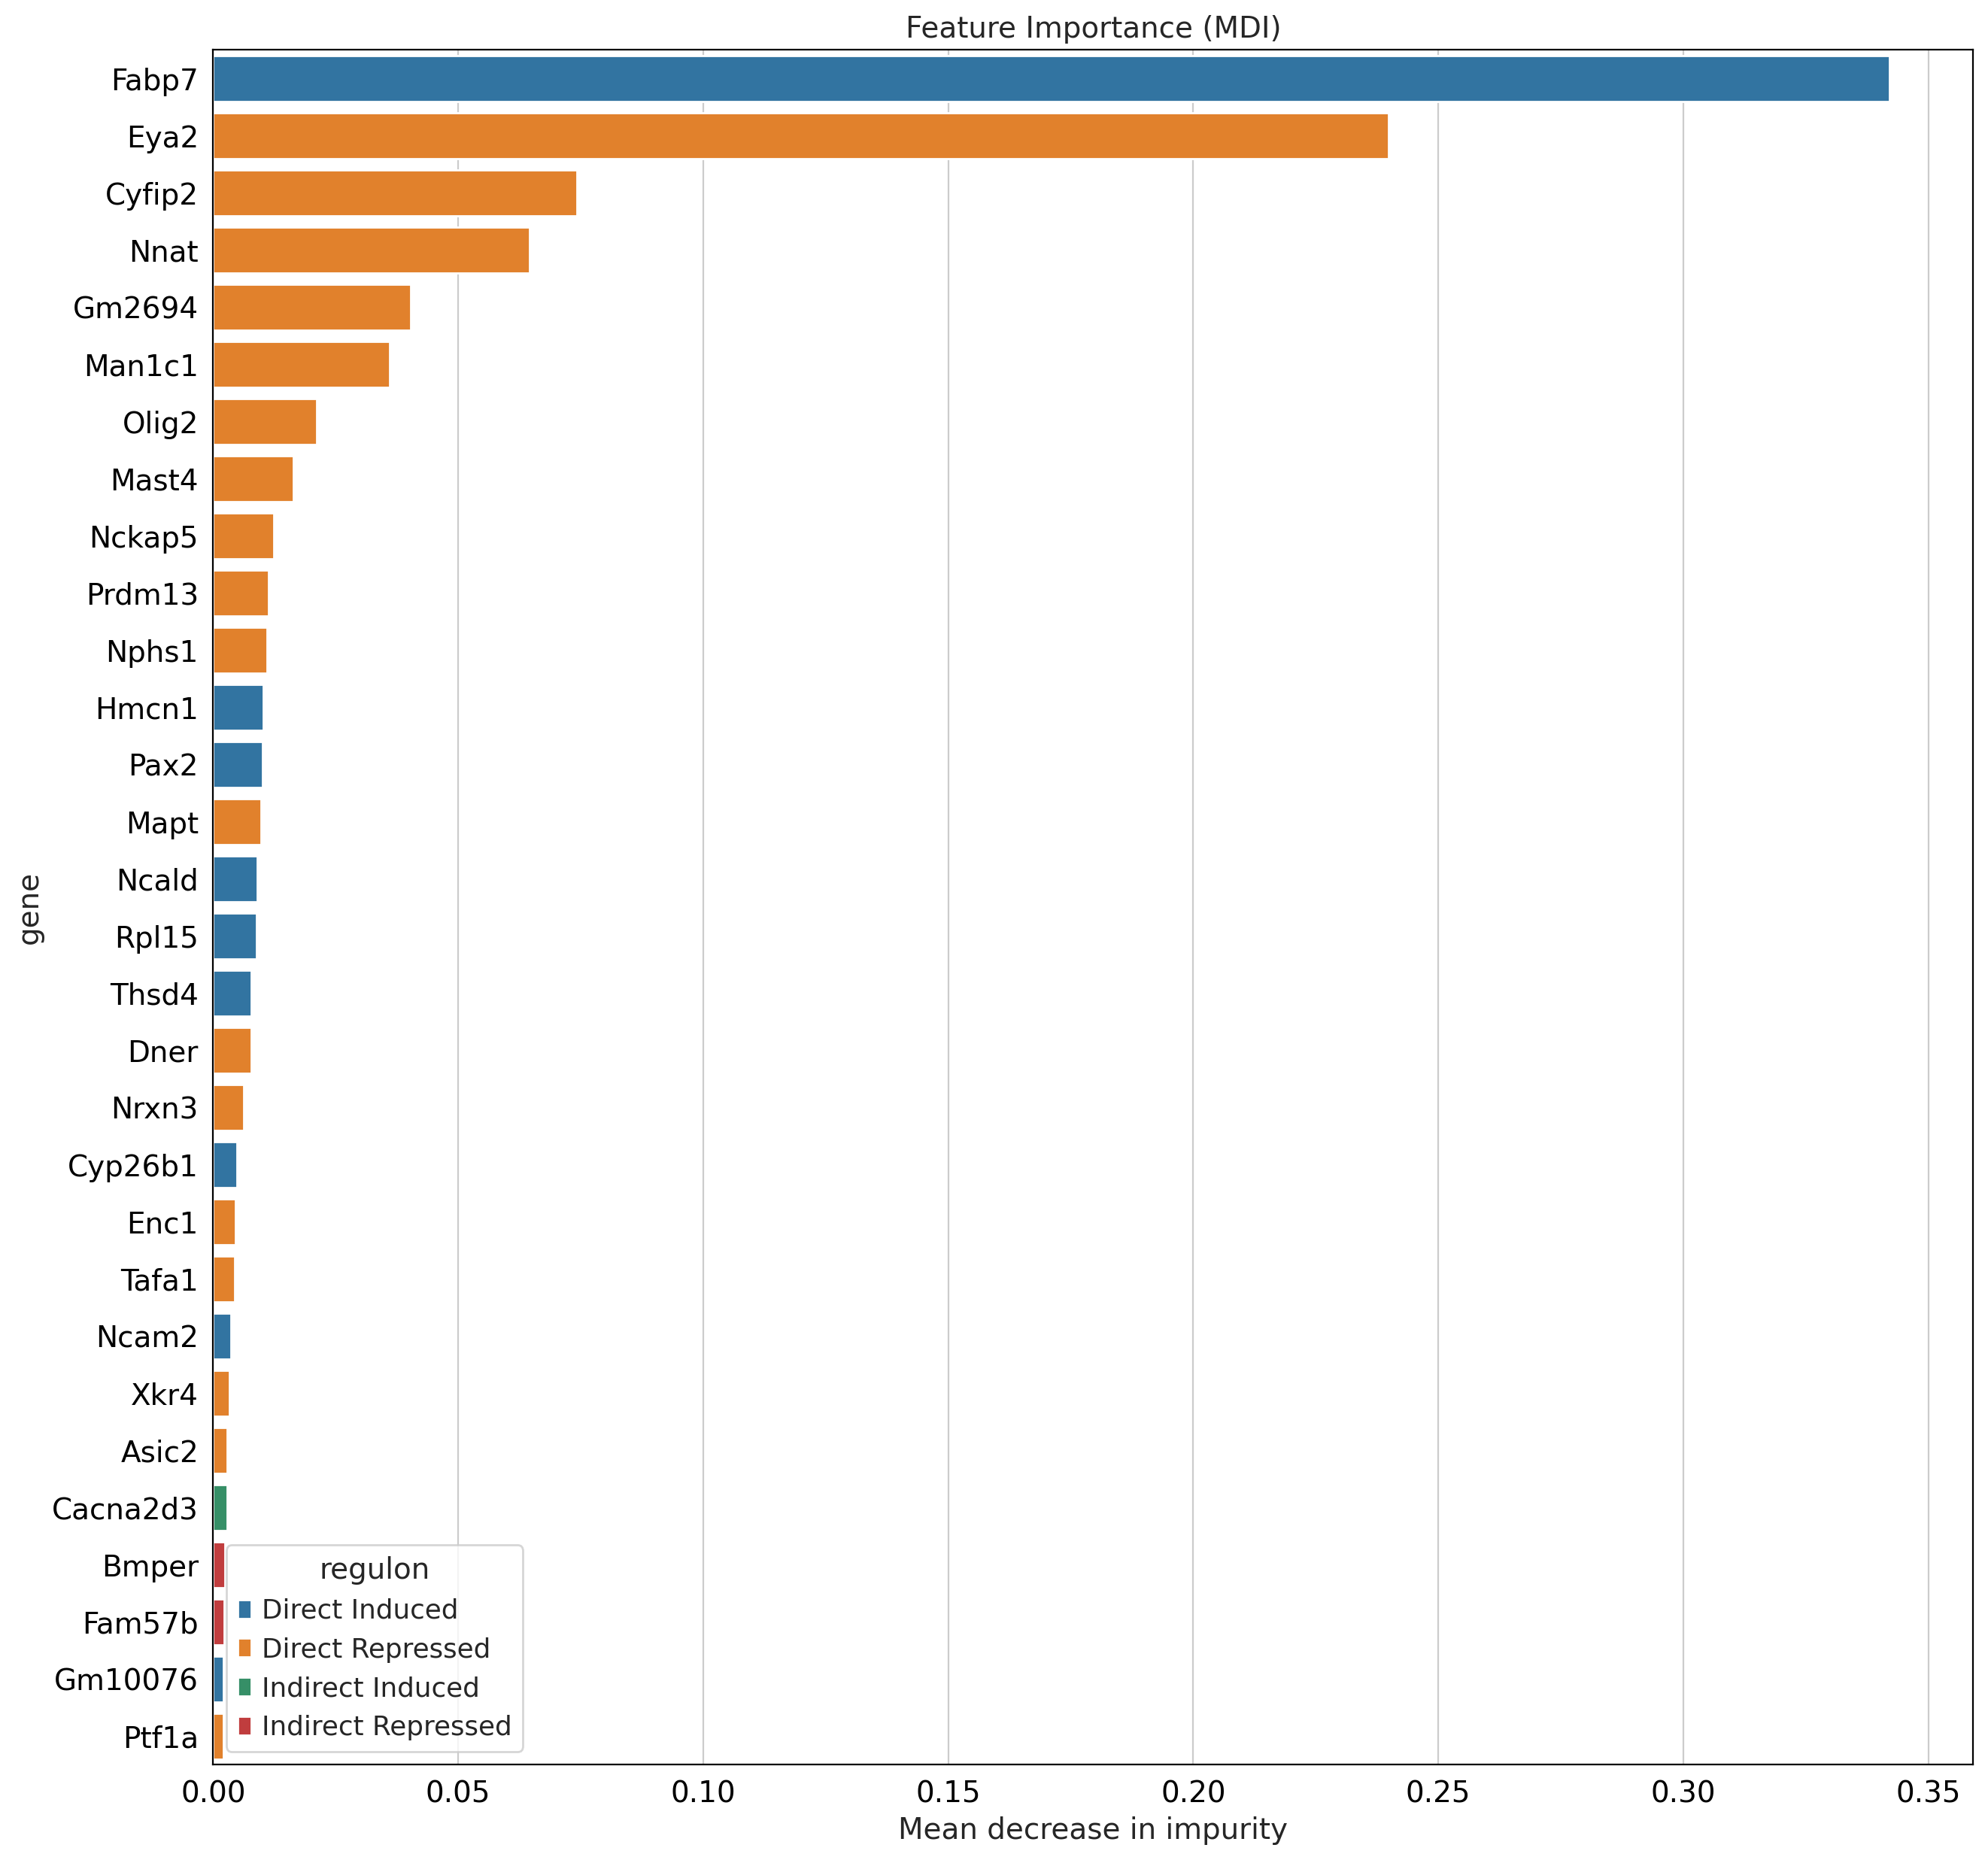

In [206]:
# plot feature importances
ax = sns.barplot(data=feature_importance[0:30], y = "gene", x=0, hue='regulon', orient='h')
ax.set(xlabel="Mean decrease in impurity", title="Feature Importance (MDI)")

# save the plot as JPEG file
plt.savefig("analysis/plots/RFplots/lineage2Importance.jpg")